# Two Sigma Connect: Rental Listing Inquiries (kaggle)
[How much interest will a new rental listing on RentHop receive?][1]

[1]:https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

#### TODO LIST
1. Spot-check algorithms
    - binarize target variable
    - MinMaxScaler for 'bathrooms', 'bedrooms', 'price'
2. Feature Engineerings
    - Deal with duplicate posts
        - Create flags for different levels of duplication
        - Will affect aggregate transformations among other things
    - Impute missing buildings
    - Make same buildings have same coordinates
 
3. Algorithms
    - A Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. http://rhiever.github.io/tpot/
    - pyglmnet
3. NLP
    - Description
        - binarize features, i.e. BOW
        - LDA with description
    - 


##### Setup (imports, constants, etc.)

In [21]:
from copy import deepcopy
import pdb
import warnings
from imp import reload
import time
from pprint import pprint
import random
from copy import deepcopy
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from grid_explore import GridSearchExplorer
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (LabelBinarizer, LabelEncoder,
                                   MinMaxScaler, StandardScaler, OneHotEncoder)
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression, RandomizedLogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from IPython.display import display
from sklearn_pandas import DataFrameMapper
import xgboost as xgb

import pdir

from outlier_detection import *
from preprocessing import *
from eda_plots import *
from validation_plots import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
REPORT_IMG_DIR = '../Report-Images/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])

scorer_acc = make_scorer(accuracy_score)

# using built-in 'neg_log_loss' scoring param used for simplicity
# source code show exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory Data Analysis

## Train vs test data

In [3]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

df.shape, df_te.shape

((49352, 14), (74659, 13))

### Are datasets random samples from same source?

In [3]:
# Same size for easier comparisons
df_te = df_te.sample(n=len(df), random_state=SEED)

Kolmogorov-Smirnov p-value: 0.981
Show sampled same distribution very likely


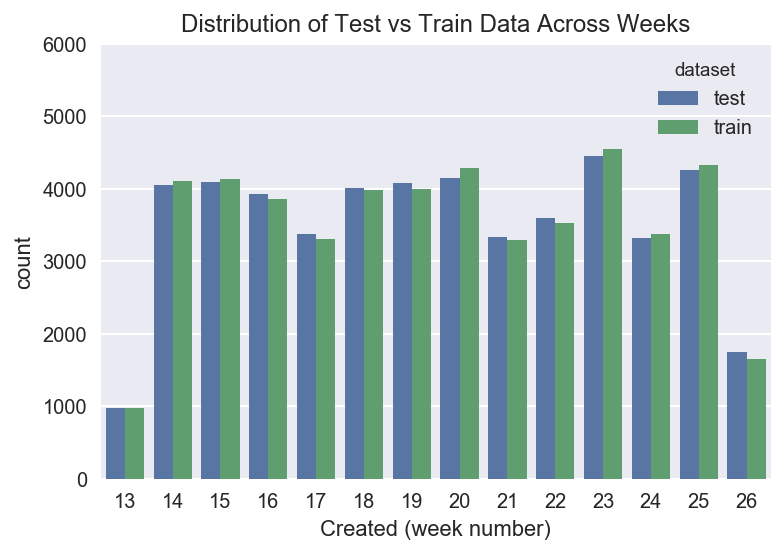

In [4]:
df_te = df_te.sample(n=len(df), random_state=SEED)
plot_count_comparison(
    x='week',
    df = df.assign(week=df.created.dt.week),
    df_te = df_te.assign(week=df_te.created.dt.week))

plt.ylim(0, 6000)
plt.xlabel('Created (week number)')
plt.title('Distribution of Test vs Train Data Across Weeks')

_, ks2_pval = stats.ks_2samp(df_te.created.dt.week, df.created.dt.week)
print('Kolmogorov-Smirnov p-value: {:.3f}'.format(ks2_pval))
print('Show sampled same distribution very likely')

plt.show()

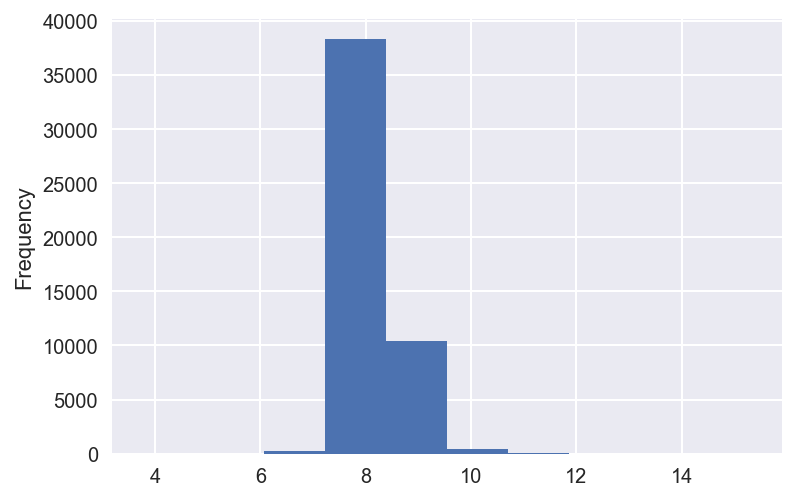

In [5]:
np.log(df.price).plot('hist')

Kolmogorov-Smirnov p-value: 0.940
Show sampled same distribution very likely


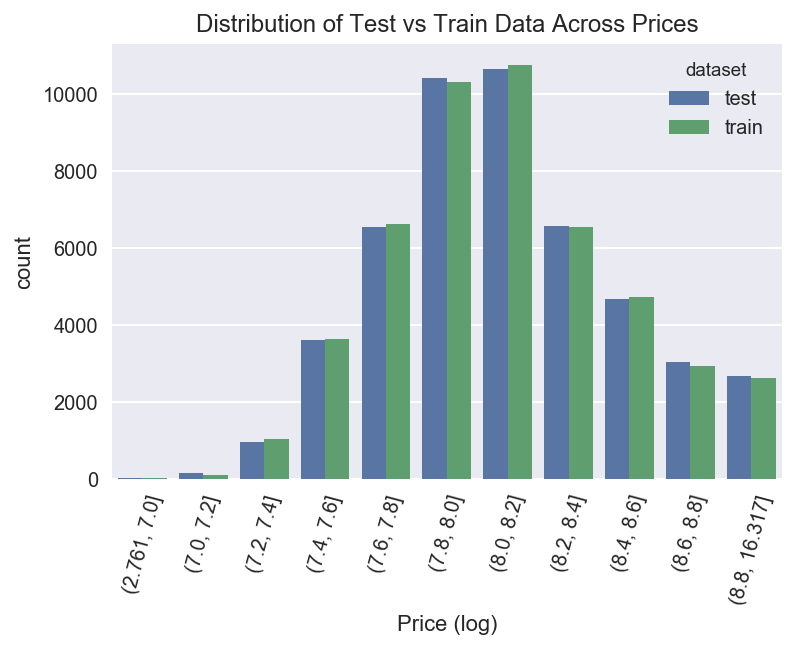

In [6]:
df_te = df_te.sample(n=len(df), random_state=SEED)

min_ = np.log(df.price.min()) - 1
max_ = np.log(df.price.max()) + 1
bins = [min_, 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.6, 8.8, max_]

data_tr = df.assign(lg_price=pd.cut(np.log(df.price), bins))
data_te = df_te.assign(lg_price=pd.cut(np.log(df_te.price), bins))

ax = plot_count_comparison(x='lg_price', df=data_tr, df_te=data_te)

plt.xticks(rotation=75)
plt.xlabel('Price (log)')
plt.title('Distribution of Test vs Train Data Across Prices')

_, ks2_pval = stats.ks_2samp(df_te.price, df.price)
print('Kolmogorov-Smirnov p-value: {:.3f}'.format(ks2_pval))
print('Show sampled same distribution very likely')

plt.show()

In [7]:
print('***Kolmogorov-Smirnov p-values***')
for name in df.drop('interest_level', axis=1).select_dtypes([int, float]).columns:
    _, ks2_pval = stats.ks_2samp(df[name], df_te[name])
    print('{:<10}: {:>5.3f}'.format(name, ks2_pval))

***Kolmogorov-Smirnov p-values***
bathrooms : 0.995
bedrooms  : 0.998
latitude  : 0.231
longitude : 0.747
price     : 0.940


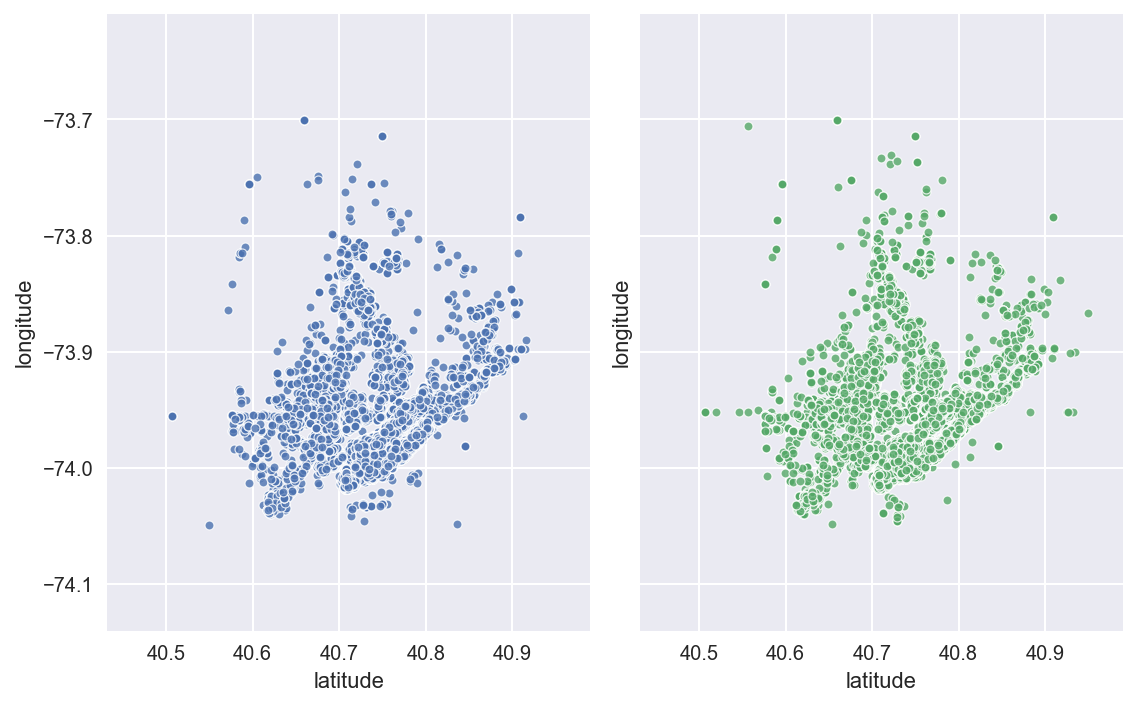

In [8]:
df1 = LatLongImputer().fit_transform(df).assign(dataset='train')
df2 = LatLongImputer().fit_transform(df_te).assign(dataset='test')

data = pd.concat([df1, df2])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5),
                               sharex=True, sharey=True)

with sns.axes_style('white'):
    for ax, df in ((ax1, df1), (ax2, df2)):
        sns.regplot(x='latitude', y='longitude', data=df, fit_reg=False,
                    ax=ax, scatter_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.tight_layout()

In [9]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

In [10]:
tr_cnts = df.manager_id.value_counts()
te_cnts = df_te.manager_id.value_counts()

merged = pd.concat([tr_cnts, te_cnts], axis=1)
n_diff = merged.isnull().any(1).sum()
n_in_both = len(merged)-n_diff
print('{:.0%} of managers in both datasets'.format(n_in_both/len(merged)))

tr_cnts = df.building_id.value_counts()
te_cnts = df_te.building_id.value_counts()

merged = pd.concat([tr_cnts, te_cnts], axis=1)
n_diff = merged.isnull().any(1).sum()
n_in_both = len(merged)-n_diff
print('{:.0%} of buildings in both datasets'.format(n_in_both/len(merged)))

67% of managers in both datasets
45% of buildings in both datasets


### Are there any rentals listed twice?

In [11]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

df_all = pd.concat([df.drop('interest_level', axis=1), df_te])
df_all.shape

(124011, 13)

In [12]:
subset = ['bedrooms', 'bathrooms', 'price', 'building_id', 'manager_id']
is_dupe = df.duplicated(subset, keep=False)
df[is_dupe].sort_values(subset).T

listing_id,6842689,7112955,6834172,6872105,7162560,7028603,6921691,7032828,6978996,7002150,...,7074029,7232801,6989183,6999811,7006884,7017467,6895545,7216315,7093306,7159729
bathrooms,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,5.00000,5.00000,2.00000,2.00000,2.00000,2.00000,3.00000,3.00000,4.00000,4.00000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,5,5,6,6,6,6,6,6,6,6
building_id,acf04eb24372da8ce23a7f73c3b099da,acf04eb24372da8ce23a7f73c3b099da,d8b20f7bd163403c49d242d50607cc0d,d8b20f7bd163403c49d242d50607cc0d,70093585319d049535fdc64e4f387da3,70093585319d049535fdc64e4f387da3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,...,4c82773ff23782a525c36ff0699cb153,4c82773ff23782a525c36ff0699cb153,216377a6c7d73665e5a15db7663b1ef4,216377a6c7d73665e5a15db7663b1ef4,0,0,216377a6c7d73665e5a15db7663b1ef4,216377a6c7d73665e5a15db7663b1ef4,c349dabcf5a949ed6817a721adb7daab,c349dabcf5a949ed6817a721adb7daab
created,2016-04-08 02:56:02,2016-06-05 02:53:45,2016-04-06 08:04:51,2016-04-14 04:09:51,2016-06-15 03:00:25,2016-05-18 02:57:34,2016-04-25 02:34:07,2016-05-18 07:22:52,2016-05-07 03:14:38,2016-05-12 05:40:54,...,2016-05-27 02:33:39,2016-06-29 06:13:27,2016-05-10 03:15:08,2016-05-12 02:43:54,2016-05-13 04:56:06,2016-05-15 05:52:33,2016-04-19 05:40:00,2016-06-25 05:28:36,2016-06-01 06:07:31,2016-06-14 15:42:54
description,Spacious studio at Sullivan Mews.Sullivan Mews...,Spacious studio at Sullivan Mews--available la...,Studio on Upper West Side,Studio on Upper West Side,"90 West Street is a beautiful pre-war, full se...","90 West Street is a beautiful pre-war, full se...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...",...,Magnificent 5 bedroom / 5 bathroom duplex pent...,Magnificent 5 bedroom / 5 bathroom duplex pent...,This beautiful 6 bedroom apartment is brand ne...,This beautiful 6 bedroom apartment is brand ne...,TRUE 6 bedrooms and are Queen sized and 2 Ful...,TRUE 6 bedrooms and are Queen sized and 2 Ful...,"NO FEE!!!, Fantastic for sharing, bright 6 Bed...","Bright, Perfect for Sharing 6 Bedroom / 3 Bath...","Unique and rare 6 bedroom, 4 bath apartment wi...","Unique and rare 6 bedroom, 4 bath apartment wi..."
display_address,115 Sullivan Street,115 Sullivan Street,W 87th St,W 87th St,90 West Street,90 West Street,East 82nd Street,East 82nd Street,East 82nd Street,East 82nd Street,...,East 94th Street,East 94th Street,W 107 St.,W 107 St.,311 Broadway,311 Broadway,West 107th Street,West 107th Street,E 70th St,E 70th St
features,"[No Fee, Exclusive, Elevator]","[No Fee, Exclusive, Elevator]",[Elevator],[Elevator],"[Fitness Center, Residents Lounge, On-site Gar...","[Fitness Center, Residents Lounge, On-site Gar...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...",...,"[Dining Room, Balcony, Doorman, Elevator, Fitn...","[Dining Room, Balcony, Doorman, Elevator, Fitn...","[Elevator, Laundry in Building, Laundry in Uni...","[Elevator, Laundry in Building, Laundry in Uni...","[Elevator, Garden/Patio, Pre-War, Laundry in U...","[Elevator, Garden/Patio, Pre-War, Laundry in U...","[Pre-War, Laundry in Building, Dogs Allowed, C...","[Pre-War, Laundry in Building, No Fee, Dogs Al...","[Elevator, Laundry in Building, Dishwasher, Ha...","[Elevator, Laundry in Building, Dishwasher, Ha..."
interest_level,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,2,1,1,1
latitude,40.72600,40.72600,40.78940,40.78940,40.71000,40.71000,40.77600,40.77600,40.77600,40.77600,...,40.78260,40.78260,40.80150,40.80150,40.71570,40.71570,40.80150,40.80150,40.76760,40.76760
longitude,-74.00260,-74.00260,-73.97640,-73.97640,-74.01430,-74.01430,-73.95560,-73.95560

In [13]:
subset = ['bedrooms', 'bathrooms', 'price', 'building_id']
is_dupe = df_all.duplicated(subset, keep=False)
df_all[is_dupe].sort_values(subset).T

listing_id,7005340,7010798,6978506,6851809,7153326,6835131,6979910,6834974,6936950,6877851,...,6823981,7122976,7059766,6943719,6983545,6937105,7110293,7061389,6878604,6926894
bathrooms,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,5.50000,5.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,7,7
building_id,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,d7b647fc80f992a06381b7f636dad338,d7b647fc80f992a06381b7f636dad338,5565db9b7cba3603834c4aa6f2950960,5565db9b7cba3603834c4aa6f2950960,5565db9b7cba3603834c4aa6f2950960,4559c07c932505a2e570a8c25f8465b6,...,87c4e08083ac83618dd9fdbf849331fe,c349dabcf5a949ed6817a721adb7daab,c349dabcf5a949ed6817a721adb7daab,0,0,0,8d83f6be6675419b19a6fc29a6ce6cee,8d83f6be6675419b19a6fc29a6ce6cee,2094beb4097c7f56670afba5b01b31a4,2094beb4097c7f56670afba5b01b31a4
created,2016-05-13 02:59:48,2016-05-14 03:01:53,2016-05-07 02:54:26,2016-04-10 02:49:58,2016-06-12 14:22:12,2016-04-06 18:12:38,2016-05-07 04:05:12,2016-04-06 18:05:35,2016-04-28 04:03:45,2016-04-15 04:59:14,...,2016-04-05 02:55:00,2016-06-08 02:10:53,2016-05-24 04:07:11,2016-04-29 06:30:33,2016-05-08 04:16:51,2016-04-28 04:14:55,2016-06-04 05:34:54,2016-05-24 05:59:12,2016-04-15 05:50:47,2016-04-26 05:37:31
description,Beautiful Studio with On Site Garage and Fitne...,In the heart of Brooklyn is a collection of in...,Fantastic Studio with On Site Garage and Fitne...,Gorgeous Studio with On Site Garage and Fitnes...,,,,,,,...,Rent listed is net effective after one month f...,"Apartment features king size six bedroom, four...",,Queen Size BedroomsEbony Hardwood FloorsRecess...,Nothing like this on the Upper East Side and 7...,Nothing like this on the Upper East Side and 7...,"This is a Brand New, Gut Renovated Large 6 Bed...","**NO FEE**This is a Brand New, Gut Renovated L...",SPECTACULAR PENTHOUSE IN THE SKY ! 5 bedroom /...,"GRAND ENTRANCE: FRAMED WITH LIMESTONE PIERS, O..."
display_address,1403 New York Avenue,1403 New York Ave.,1403 New York Avenue,1403 New York Avenue,Clarendon Rd,Clarendon Rd,Broadway,Broadway,Broadway,Grand Central Parkway West,...,E 77 St.,"E 70th St,",East 70th Street,East 75th Street,East 75th Street,East 75th Street,East 75th Street,East 75th Street\r,East 39th Street,East 39th Street
features,"[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...",[],[],"[Elevator, No Fee]",[Elevator],"[Elevator, No Fee]",[],...,"[Pre-War, Laundry in Unit, Dishwasher, Hardwoo...","[private-outdoor-space, balcony, Elevator, Sta...","[Doorman, Elevator, Cats Allowed, Dogs Allowed]","[Laundry in Unit, Dishwasher, Hardwood Floors,...","[Dining Room, Laundry in Unit, Dishwasher, Har...","[Dining Room, Laundry in Unit, Dishwasher, Har...","[Pre-War, Laundry in Unit, Hardwood Floors, No...","[Dining Room, Pre-War, Laundry in Unit, Dishwa...","[Fireplace, Swimming Pool, Roof Deck, Dining R...","[Swimming Pool, Roof Deck, Dining Room, Balcon..."
latitude,40.63860,40.63860,40.63860,40.63860,40.64350,40.64350,40.81980,40.81980,40.81980,40.71960,...,40.77160,40.76760,40.76760,40.77010,40.77010,40.77010,40.77010,40.77010,40.74790,40.74790
longitude,-73.94500,-73.94500,-73.94500,-73.94500,-73.94280,-73.94280,-73.95780,-73.95780,-73.95780,-73.83510,...,-73.95440,-73.96010,-73.96010,-73.95500,-73.95500,-73.95500,-73.95500,-73.95500,-73.97460,-73.97460
manager_id,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9556a2e6dd5f856dfaf77cd09fb8af38,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,e6472c7237327dd3903b3d6f6a94515a,...,e6472c7237327dd3903b3d6f6a9

Duplicates on everything

In [14]:
data = df_all

subset = (data.drop(['manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)
is_dupe = data.duplicated(subset, keep=False)
data[is_dupe].sort_values(subset).T

listing_id,6827050,7485494,7121825,6834448,7121804,6840762,7670925,6862495,6862503,7206163,...,7025421,7025420,7025763,7025764,7025922,7025923,7025164,7025163,7186031,7186030
bathrooms,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,2.50000,2.50000,3.00000,3.00000,3.00000,3.00000,3.50000,3.50000,4.50000,4.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,4,4,4,4
building_id,0,0,0,0,0,0,0,0,0,0,...,b6a10b3e057d5ed75fb7ff31b83bf0b1,b6a10b3e057d5ed75fb7ff31b83bf0b1,1f08a2db498242410566a351799b12f0,1f08a2db498242410566a351799b12f0,5946e4ecda0d333735c2b04b5f4ec2e0,5946e4ecda0d333735c2b04b5f4ec2e0,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,3471bc324ab99b92a5b56763d25c8cf3,3471bc324ab99b92a5b56763d25c8cf3
created,2016-04-05 12:44:57,2016-04-05 12:44:57,2016-04-06 12:54:03,2016-04-06 12:54:03,2016-04-07 14:40:14,2016-04-07 14:40:14,2016-04-12 11:50:05,2016-04-12 11:50:05,2016-04-12 12:02:03,2016-04-12 12:02:03,...,2016-05-17 14:29:08,2016-05-17 14:29:08,2016-05-17 14:38:04,2016-05-17 14:38:04,2016-05-17 14:41:01,2016-05-17 14:41:01,2016-05-17 14:24:29,2016-05-17 14:24:29,2016-06-20 19:12:33,2016-06-20 19:12:33
description,TAKE A REDUCED FEE OR $ 1000 BONUS! \r\rStudio...,TAKE A REDUCED FEE OR $ 1000 BONUS! \r\rStudio...,This studio apartment has been newly renovated...,This studio apartment has been newly renovated...,This spacious studio apartment is right in the...,This spacious studio apartment is right in the...,- Beautiful Studio- Brand New Kitchen Applianc...,- Beautiful Studio- Brand New Kitchen Applianc...,Renovated studio apartment has new kitchen and...,Renovated studio apartment has new kitchen and...,...,This large convertible 3 bedroom soaked with n...,This large convertible 3 bedroom soaked with n...,Massive renovated 3 bedroom in a PreWar buildi...,Massive renovated 3 bedroom in a PreWar buildi...,"This is a Brand New, Gut Renovated 3 Bedroom D...","This is a Brand New, Gut Renovated 3 Bedroom D...",Large converted 4 BR/3.5 BA home w/ panoramic ...,Large converted 4 BR/3.5 BA home w/ panoramic ...,Sprawling floor-thru Penthouse unit located in...,Sprawling floor-thru Penthouse unit located in...
display_address,West Street,West Street,John St,John St,Wall St,Wall St,E 61 st,E 61 st,South End Avenue,South End Avenue,...,E 70th St.,E 70th St.,E 72nd St.,E 72nd St.,E 81 St.,E 81 St.,East 56th Street,East 56th Street,E 57 St.,E 57 St.
features,"[Common Outdoor Space, Laundry In Unit, Cats A...","[Common Outdoor Space, Laundry In Unit, Cats A...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Cats Allowed, Dogs Allowed, Elevator, Laundry...","[Cats Allowed, Dogs Allowed, Elevator, Laundry...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...",...,"[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Doorman, Elevator, Pre-War, Laun...","[Dining Room, Doorman, Elevator, Pre-War, Laun...","[Multi-Level, Pre-War, Laundry in Unit, Dishwa...","[Multi-Level, Pre-War, Laundry in Unit, Dishwa...","[Roof Deck, Doorman, Elevator, Laundry in Buil...","[Roof Deck, Doorman, Elevator, Laundry in Buil...","[Balcony, Doorman, Elevator, Terrace, Laundry ...","[Balcony, Doorman, Elevator, Terrace, Laundry ..."
latitude,40.70530,40.70530,40.70760,40.70760,40.70330,40.70330,40.76270,40.76270,40.71580,40.71580,...,40.76790,40.76790,40.76880,40.76880,40.77390,40.77390,40.75790,40.75790,40.75820,40.75820
longitude,-74.01140,-74.01140,-74.01050,-74.01050,-74.01400,-74.01400,-73.96900,-73.96900,-74.01560,-74.01560,...,-73.95980,-73.95980,-73.95920,-73.95920,-73.95290,-73.95290,-73.96530,-73.96530,-73.96340,-73.96340
manager_id,3734dac511776b0990e90a94d71c8251,3734dac511776b0990e90a94d71c8251,d12f4c3b61d726c5b7f74ff

In [15]:
data = df.drop('interest_level', axis=1)

subset = (data.drop(['manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)
is_dupe = data.duplicated(subset, keep=False)
data[is_dupe].sort_values(subset).T

listing_id,6868769,7222580,7547579,7133023,7485458,7023521,7025062,7025061,7155593,6822458,...,7056185,6956382,7056191,6956411,7019955,7567437,7025646,7025645,7025421,7025420
bathrooms,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.50000,2.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,2,2,3,3,3,3,3,3,3,3
building_id,0,0,0,0,c94301249b8c09429d329864d58e5b82,c94301249b8c09429d329864d58e5b82,d16f875956b264d5920d8424631091d4,d16f875956b264d5920d8424631091d4,fcd0bca4ee9c7bd444dbba39e8caa4fe,fcd0bca4ee9c7bd444dbba39e8caa4fe,...,f5e2cdb7a92059ee5e3dbd97b03f03ce,f5e2cdb7a92059ee5e3dbd97b03f03ce,315a2f868a195b076e5be73411110da2,315a2f868a195b076e5be73411110da2,d0234abbc01a982d54e8d446acc03405,d0234abbc01a982d54e8d446acc03405,dd7b281c0dbafc8b53575ab78cca75d4,dd7b281c0dbafc8b53575ab78cca75d4,b6a10b3e057d5ed75fb7ff31b83bf0b1,b6a10b3e057d5ed75fb7ff31b83bf0b1
created,2016-04-13 12:53:40,2016-04-13 12:53:40,2016-06-09 18:48:01,2016-06-09 18:48:01,2016-05-17 11:16:30,2016-05-17 11:16:30,2016-05-17 14:21:48,2016-05-17 14:21:48,2016-04-04 18:44:53,2016-04-04 18:44:53,...,2016-05-03 02:57:23,2016-05-03 02:57:23,2016-05-03 02:58:11,2016-05-03 02:58:11,2016-05-16 12:49:47,2016-05-16 12:49:47,2016-05-17 14:35:36,2016-05-17 14:35:36,2016-05-17 14:29:08,2016-05-17 14:29:08
description,"Spacious studio with oversized entry doors, hi...","Spacious studio with oversized entry doors, hi...",RENOVATED studio apartment. GREAT layout..feat...,RENOVATED studio apartment. GREAT layout..feat...,**IMMEDIATE OCCUPANCY** \r\rThis luxury St...,**IMMEDIATE OCCUPANCY** \r\rThis luxury St...,FEATURES:Custom European CabinetryGranite Coun...,FEATURES:Custom European CabinetryGranite Coun...,BETWEEN 65TH AND 66TH STREET \r\r*****BEST LOC...,BETWEEN 65TH AND 66TH STREET \r\r*****BEST LOC...,...,,,,,Great 2BDR convertible to 3BDR with windows in...,Great 2BDR convertible to 3BDR with windows in...,***INCREDIBLE BEAUTIFUL APARTMENT IN MURRAY HI...,***INCREDIBLE BEAUTIFUL APARTMENT IN MURRAY HI...,This large convertible 3 bedroom soaked with n...,This large convertible 3 bedroom soaked with n...
display_address,Financial District,Financial District,E 91st St,E 91st St,gold st.,gold st.,John St.,John St.,Lexington Ave Btwn 65th and 66th St.,Lexington Ave Btwn 65th and 66th St.,...,E 18th St,E 18th St,Avenue B,Avenue B,"W34 Drmn, Gym, Rooftop,","W34 Drmn, Gym, Rooftop,",Second Avenue,Second Avenue,E 70th St.,E 70th St.
features,"[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Cats Allowed, Elevator]","[Cats Allowed, Elevator]","[Cats Allowed, Dogs Allowed, No Fee, Elevator,...","[Cats Allowed, Dogs Allowed, Reduced Fee, Elev...","[Roof Deck, Doorman, Elevator, Fitness Center,...","[Roof Deck, Doorman, Elevator, Fitness Center,...",[],[],...,"[Cats Allowed, Dogs Allowed, Washer/Dryer, Dis...","[Cats Allowed, Dogs Allowed, Washer/Dryer, Dis...","[Washer/Dryer, Dishwasher]","[Washer/Dryer, Dishwasher]","[Cats Allowed, Dogs Allowed, No Fee, Doorman, ...","[Cats Allowed, Dogs Allowed, No Fee, Doorman, ...","[Balcony, Doorman, Elevator, Fitness Center, L...","[Balcony, Doorman, Elevator, Fitness Center, L...","[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Balcony, Doorman, Elevator, Terr..."
latitude,40.70870,40.70870,40.78150,40.78150,40.70840,40.70840,40.70750,40.70750,40.76620,40.76620,...,40.73440,40.73440,40.72790,40.72790,40.75220,40.75220,40.74130,40.74130,40.76790,40.76790
longitude,-74.01380,-74.01380,-73.95040,-73.95040,-74.00870,-74.00870,-74.00590,-74.00590,-73.96560,-73.96560,...,-73.98230,-73.98230,-73.97940,-73.97940,-73.99400,-73.99400,-73.97810,-73.97810,-73.95980,-73.95980
manager_id,e6472c7237327dd3903b3d6f6a94515a,e6472c7237327dd3903b3d6f6a94515a,2ec6c71d78dd9df9046ce6899ec42de8,2ec6c71d78dd9df9046ce6899ec42de8,43fd90ca9d06dd61aa8f985e61f9a0c0,43fd90ca9d06dd61aa8f985e61f9a0c0,501b52559fd21b3

In [16]:
data = df.drop(['interest_level'], axis=1)
data = df
data = (data.assign(n_feats=data.features.apply(lambda x: len(x)))
            .assign(n_photos=data.photos.map(lambda x: len(x)))
)

subset = (data.drop(['created', 'manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)

is_dupe = data.duplicated(subset, keep=False)
print('same time, same manager: {}'.format(is_dupe.sum()))

same time, same manager: 5230


In [81]:
data = df.drop(['interest_level'], axis=1)

subset = (data.drop(['created', 'features', 'photos'], axis=1)
              .columns.tolist()
)


is_dupe = data.duplicated(subset, keep=False)
print('dupes for {}'.format('4'))
print(is_dupe.sum())

for col in ['description', 'price']:

    subset.remove(col)
    is_dupe = data.duplicated(subset, keep=False)
    print('dupes with different {}'.format(col))
    print(is_dupe.sum())

dupes for 4
74
dupes with different created
7123
dupes with different description
8329
dupes with different price
13625


## Interest Level

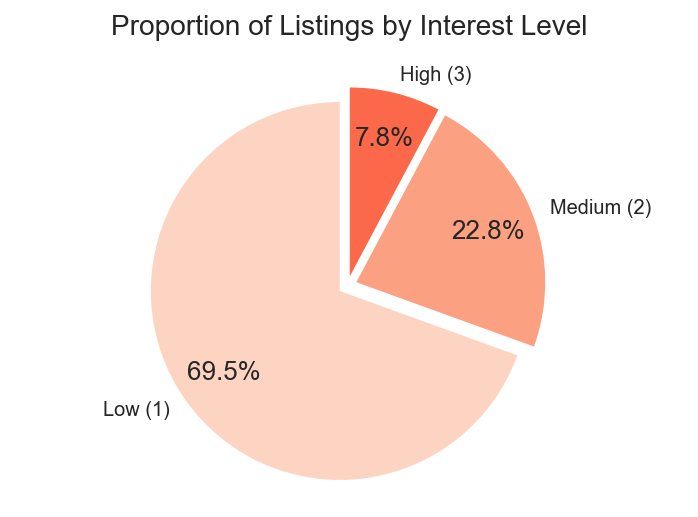

In [62]:
ax = plot_interest_pie(df.interest_level, textprops=dict(fontsize=13), pctdistance=.75)
ax.set_title(ax.get_title(), fontdict=dict(fontsize=14))

# plt.savefig(''.join([REPORT_IMG_DIR, '1-interest-pie.png']), dpi=600)
plt.show()


## Price

__Distribution__

count             inf
mean       3291.28121
std           1.54163
min          43.00000
25%        2500.00000
50%        3150.00000
75%        4100.00000
max     4490000.00000
Name: lg_price, dtype: float64

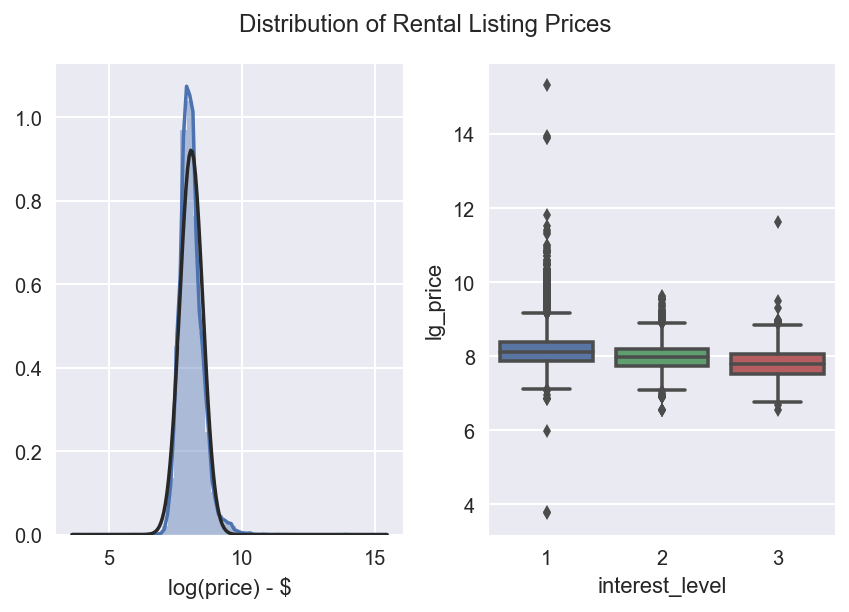

In [88]:
data = df.assign(lg_price=np.log(df.price))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 4))
sns.distplot(data.lg_price, fit=stats.norm, ax=ax1)
ax1.set_xlabel('log(price) - $')

sns.boxplot(y='lg_price', x='interest_level', data=data, ax=ax2)
plt.suptitle('Distribution of Rental Listing Prices', y=1.05)

plt.tight_layout()

# Std not accurate given transformations
display(data.lg_price.describe().apply(np.exp))

__Missing__

In [65]:
df.price.sort_values().head(10)

listing_id
7060255     43
6813772     45
6871682    401
6865783    695
6852585    695
6831246    695
6859573    695
7127753    700
6934177    800
6952911    868
Name: price, dtype: int64

Can consider 43 and 45 vals as missing values

__Missing Data and Outliers__

In [67]:
k = 3
price_outls = df[is_price_outl(df.price, k=k)].price

n_outl = len(price_outls)
print('{} ({:.2%}) outliers found with Tukey test with k={}'
      .format(n_outl, n_outl/len(df), k))
display(price_outls.sort_values().head())
display(price_outls.sort_values().tail())

165 (0.33%) outliers found with Tukey test with k=3


listing_id
7060255       43
6813772       45
6871682      401
7179590    18295
7209856    18457
Name: price, dtype: int64

listing_id
6857401     135000
7013217    1070000
7036279    1070000
7208794    1150000
7208764    4490000
Name: price, dtype: int64

__Relevance__

In [197]:
data.lg_price.min()

6.543911845564792

lg_price chi2 p-val = 0.0000 (rounded)


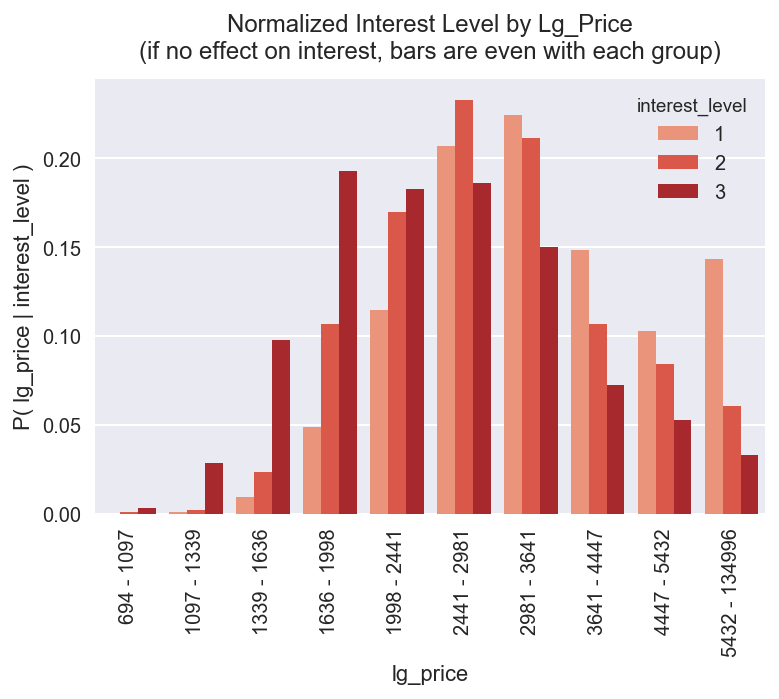

In [259]:
data = df.assign(lg_price=np.log(df.price))
data = PriceOutlierDropper().fit_transform(data)

bins = [data.lg_price.min(), 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.6,
        data.lg_price.max()]
plot_prob_x_for_hue(x='lg_price', data=data, hue='interest_level',
                    bins=bins, exp_xlabels=True)

# plt.savefig(''.join([REPORT_IMG_DIR, '2-price-on-interest.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

## Bedrooms and Bathrooms

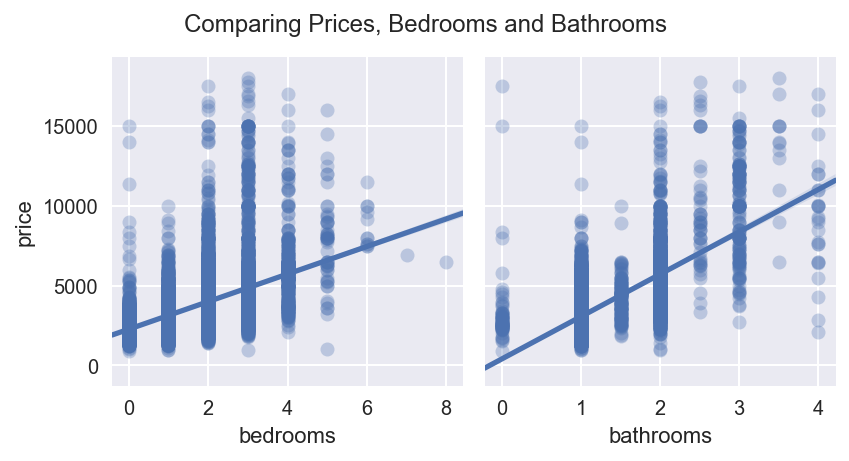

In [140]:
data = df[['bedrooms', 'bathrooms', 'price']]
data = drop_price_outl(data, k=3, msg=False)  # for plotting
data = data.sample(frac=.2, random_state=SEED)  # for performance

sns.pairplot(
    data=data,
    x_vars=['bedrooms', 'bathrooms'],
    y_vars=['price'],
    kind='reg',
    size=3,
    plot_kws=dict(scatter_kws=dict(alpha=.3)),
)
plt.suptitle('Comparing Prices, Bedrooms and Bathrooms', y=1.05)
plt.tight_layout()

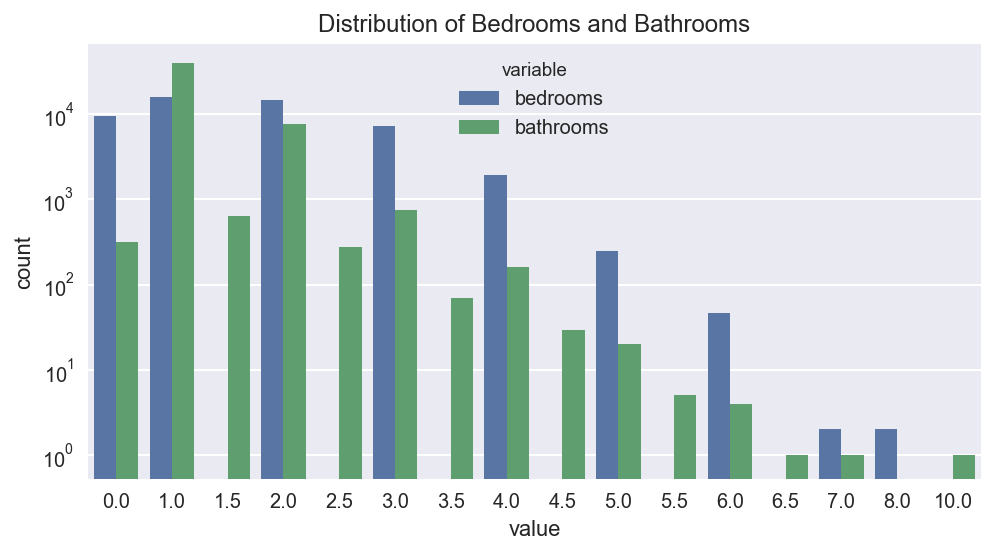

In [141]:
data = pd.melt(df, value_vars=['bedrooms', 'bathrooms'])
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='value', hue='variable', data=data, log=True)
plt.title('Distribution of Bedrooms and Bathrooms')

# plt.savefig(''.join([REPORT_IMG_DIR, '4-bed-bath-dist.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

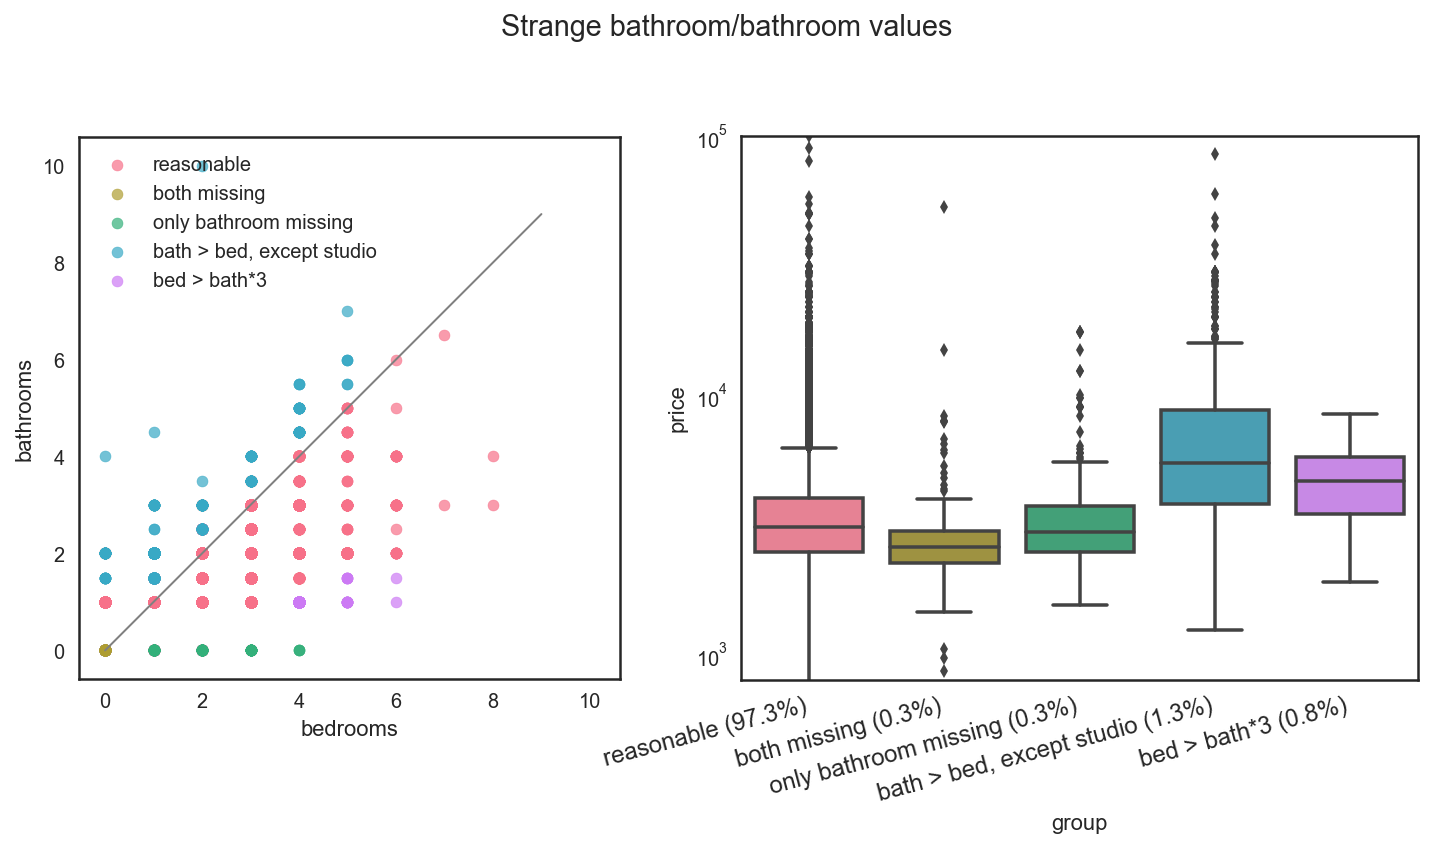

group counts


reasonable                   48023
bath > bed, except studio      634
bed > bath*3                   382
both missing                   157
only bathroom missing          156
Name: group, dtype: int64


Median Price by Group


group
bath > bed, except studio   5500.00000
bed > bath*3                4695.00000
both missing                2595.00000
only bathroom missing       2982.49057
reasonable                  3105.00000
Name: price, dtype: float64

In [142]:
data = set_bedbath_groups(df)

with sns.axes_style('white'):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5),
                                   gridspec_kw=dict(width_ratios=[4, 5]))

    grouped = data.groupby('group')
    
    group_order = ['reasonable', 'both missing', 'only bathroom missing',
                   'bath > bed, except studio', 'bed > bath*3']
    
    group_colors = sns.color_palette('husl', 5).as_hex()
    for color, name in zip(group_colors, group_order):
        group = grouped.get_group(name)
        group.plot(kind='scatter', x='bedrooms', y='bathrooms', label=name,
                   ax=ax1, color=color, s=30, alpha=.7)
    ax1.plot([0,9], [0,9], 'gray', linewidth=1)
    ax1.axis('square')
    ax1.legend(fontsize='medium')

    sns.boxplot(y='price', x='group', data=data,
                order=group_order, palette=group_colors, ax=ax2)

    xticklabels = []
    cnts = data.group.value_counts(normalize=True)
    for t in ax2.get_xticklabels():
        lbl = t.get_text()
        s = '{} ({:.1%})'.format(lbl, cnts[lbl])
        xticklabels.append(s)

    ax2.set_xticklabels(xticklabels, fontsize='large',
                        rotation=15, ha='right')
    ax2.set_yscale('log')
    ax2.set_ylim(800, 1e5)

    plt.suptitle('Strange bathroom/bathroom values', fontsize='x-large',
                 y=1.05)

    plt.savefig(''.join([REPORT_IMG_DIR, '3-strange-bed-bath.png']),
                dpi=600, bbox_inches='tight')
    plt.show()
    
print('group counts')
display(data.group.value_counts())
print()
print('Median Price by Group')
display(data.groupby('group')['price']
        .apply(lambda x: np.exp(np.median(np.log(x)))))

group chi2 p-val = 0.0000 (rounded)


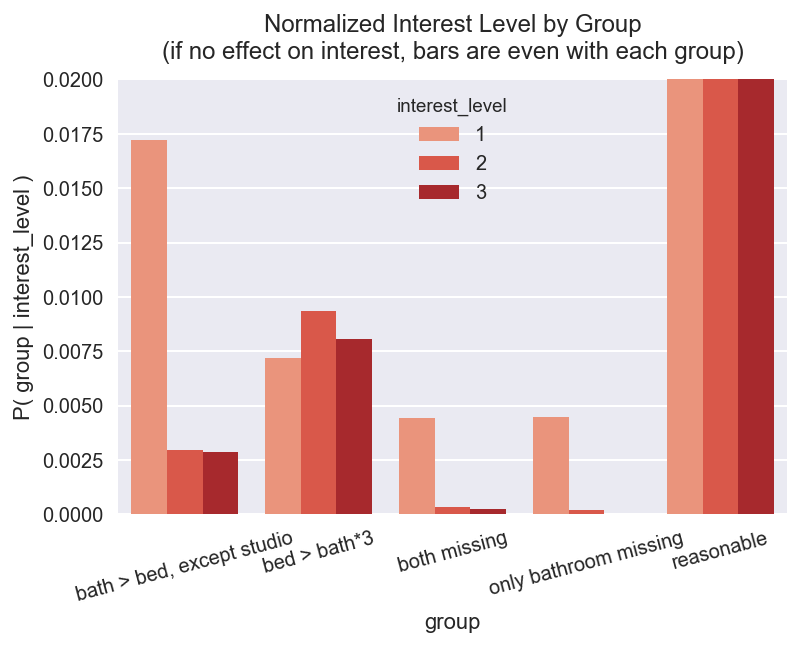

In [211]:
data = set_bedbath_groups(df)

ax = plot_prob_x_for_hue(x='group', data=data, hue='interest_level')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
plt.ylim(0, .02)
plt.show()

bedrooms chi2 p-val = 0.0000 (rounded)


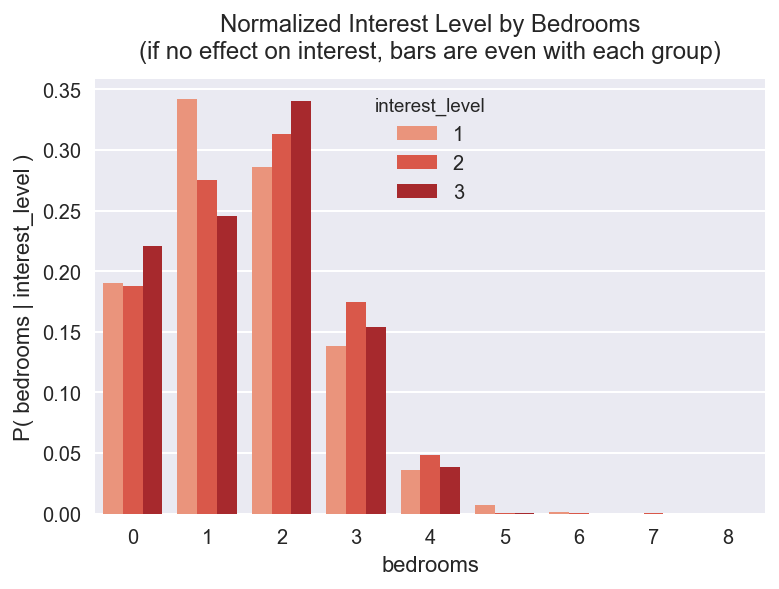

In [212]:
data = df
plot_prob_x_for_hue(x='bedrooms', data=data, hue='interest_level')
plt.show()

## Geo-coordinates and Buildings

In [217]:
df[df.latitude==0].shape

(12, 14)

Dropped 68 geo-coordinate outliers (0.14%)


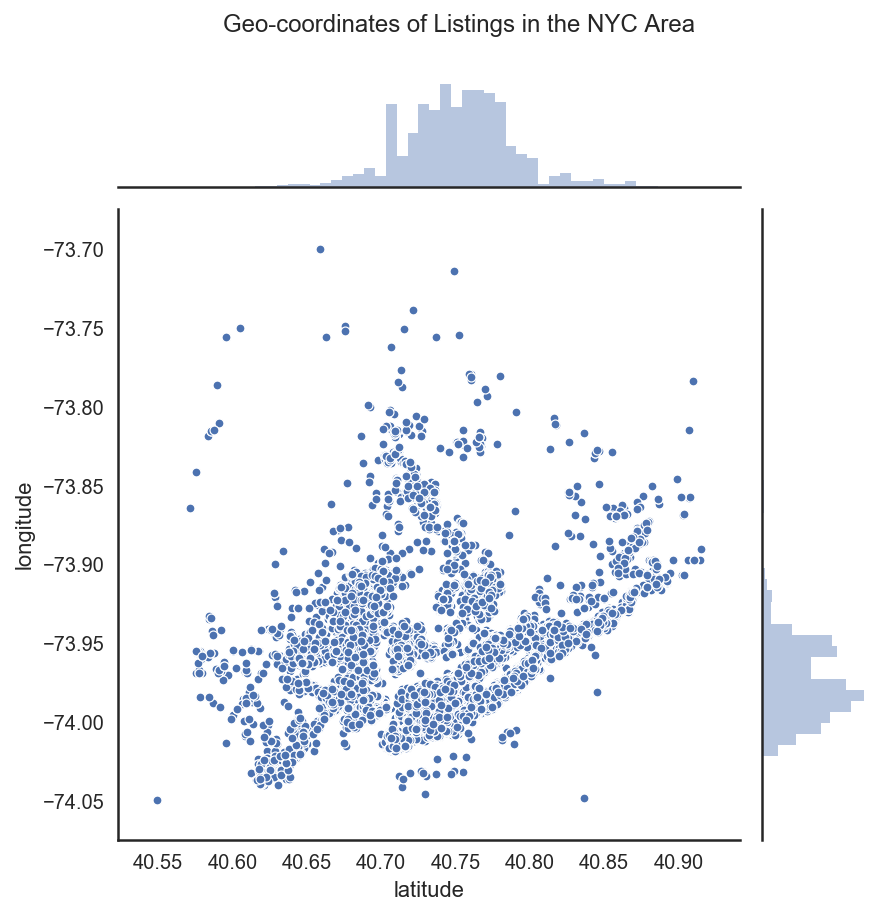

In [223]:
data = drop_geo_outl(df)
with sns.axes_style('white'):
    sns.jointplot('latitude', 'longitude', data=data, stat_func=None,
                  joint_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.suptitle('Geo-coordinates of Listings in the NYC Area', y=1.05)
# plt.savefig(''.join([REPORT_IMG_DIR, '5-geo-coordinates.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

### Buildings vs Coordinates

Q: Is latitude and longitude determined by building?

A: No

In [120]:
print('Num buildings: {}'.format(len(df.building_id.unique())))
print('Num missing buildings: {}'.format(len(df[df.building_id=='0'])))

Num buildings: 7585
Num missing buildings: 8286


In [55]:
def has_same_coords(df):
    return df.duplicated(keep=False).all().all()

same_coords_dat = df.groupby('building_id')['latitude', 'longitude'].apply(
    lambda x: has_same_coords(x) if len(x) > 1 else np.nan
)
print('{} total buildings'.format(len(df.building_id.unique())))
print('{} only have one listing'.format((same_coords_dat.isnull()).sum()))
print('{} with same co-ordinates'.format(same_coords_dat.sum()))
print('{} with different co-ordinates'.format((same_coords_dat==False).sum()))

7585 total buildings
3659 only have one listing
2942 with same co-ordinates
984 with different co-ordinates


In [99]:
df[df.building_id=='0'].duplicated(['latitude', 'longitude'], keep=False).sum()

6291

How many geo-coordinate locations have multiple buildings?

In [117]:
building_diff = (df.groupby(['latitude', 'longitude'])['building_id']
                   .apply(lambda x: len(x.unique()))
                   .sort_values(ascending=False)
)

print((building_diff > 1).sum())
display(building_diff.head())

2219


latitude  longitude
0.00000   0.00000      11
40.71280  -74.00590     8
40.70690  -74.01040     4
40.74920  -73.97890     4
40.77920  -73.95140     4
Name: building_id, dtype: int64

How many buildings have listings with different geo-coordinates?

In [112]:
data = df.query('latitude != 0 and longitude != 0')
geo_coord_diff = (data.groupby('building_id')['latitude', 'longitude']
                    .apply(lambda x: x.max() - x.min())
)

print((geo_coord_diff.sum(1) > 0).sum())
display(geo_coord_diff.sort_values('latitude', ascending=False).head(20))
display(geo_coord_diff.sort_values('longitude', ascending=False).head(20))

1439


,latitude,longitude
building_id,,
cca9ed74339903b6d9c876a8e608d75b,4.12000,19.31200
0,2.91870,5.62760
437454e6d44ae7c94f60b1b6507d084a,0.91780,12.18180
ebdf422b8605d69a719a5cdc34019463,0.87690,0.66750
6869a3c2a96003e9992d6cd1c3c4b299,0.71720,1.53520
cd759a988b8f23924b5a2058d5ab2b49,0.16170,0.05060
3a6e1c689ffe82c668efccdcabb3664d,0.14260,0.07980
0dfc470e829c89405e597fd0bb9a4c55,0.07450,0.03260
b809c009c803e70c221317657ea96ec8,0.06700,0.08440


,latitude,longitude
building_id,,
cca9ed74339903b6d9c876a8e608d75b,4.12000,19.31200
437454e6d44ae7c94f60b1b6507d084a,0.91780,12.18180
0,2.91870,5.62760
6869a3c2a96003e9992d6cd1c3c4b299,0.71720,1.53520
95fabd330f806524ae62115264f1f840,0.02020,0.71240
ebdf422b8605d69a719a5cdc34019463,0.87690,0.66750
39dd015bc8b81e4ae8b667357b8620b4,0.03150,0.19900
c391084ee341be0d85643b7bd1757993,0.03850,0.13900
888101a642929bc225eae5f809a70bc8,0.02000,0.10890


Rounding geo-coordinates:
- Latitude
    - "Each degree of latitude is approximately 69 miles (111 kilometers) apart."
    - 5 ft = 0.00094697 miles = 0.000013724 degrees
    - 
- Longitude
    - "At 40° north or south, the distance between a degree of longitude is 53 miles (85 kilometers)."
    - 5 ft = 0.00094697 miles = 0.000017867 degrees


Source: https://www.thoughtco.com/degree-of-latitude-and-longitude-distance-4070616

## Dates

day_name chi2 p-val = 0.0000 (rounded)
month chi2 p-val = 0.3784 (rounded)


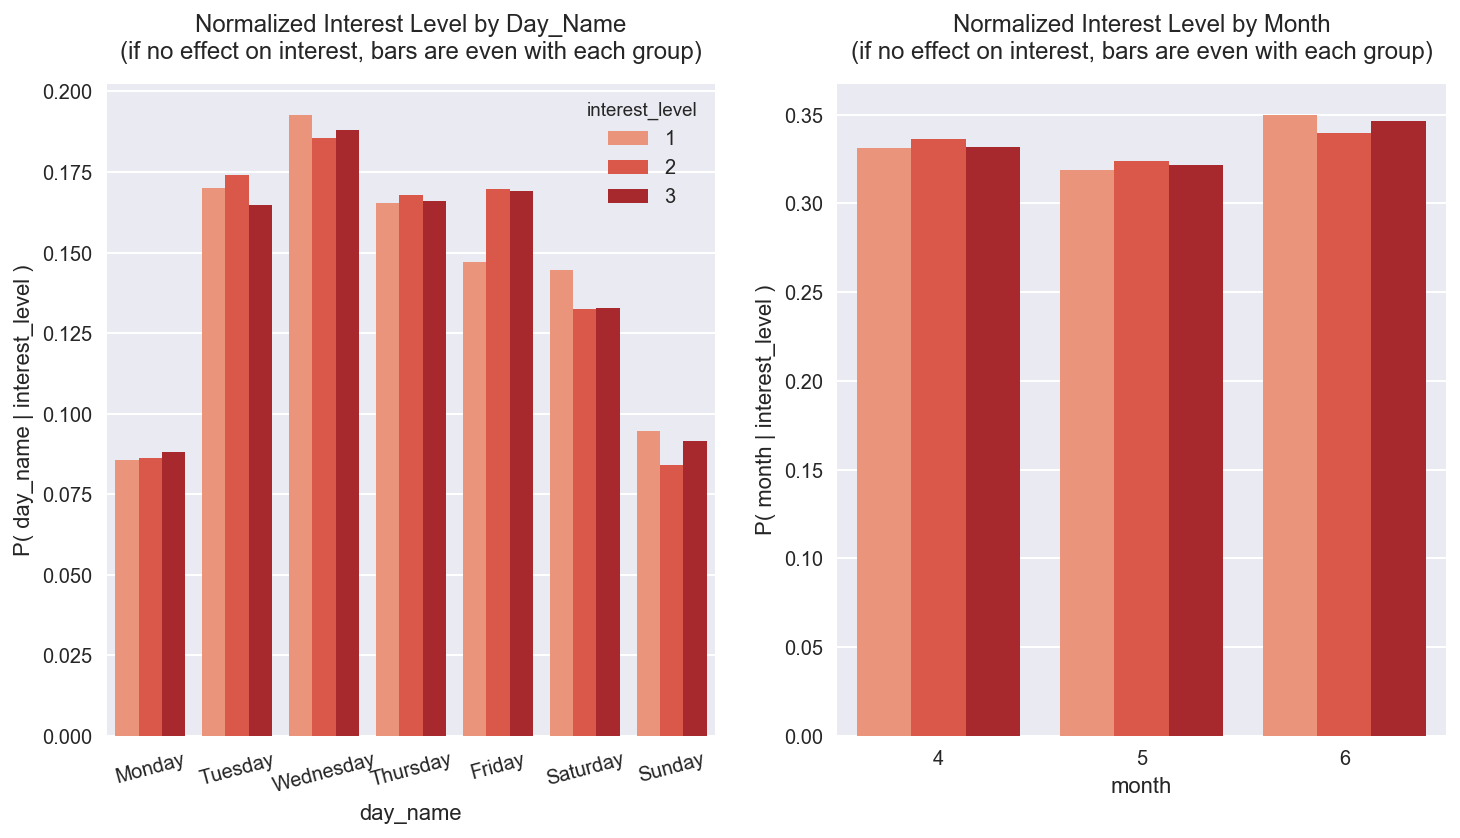

In [213]:
df['month']    = df.created.map(lambda x: x.month).astype(int)
df['day']      = df.created.map(lambda x: x.day).astype(int)
df['day_name'] = df.created.dt.weekday_name

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plot_prob_x_for_hue(x='day_name', data=df, hue='interest_level',
                    bins=None, order=day_order, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

plot_prob_x_for_hue(x='month', data=df, hue='interest_level',
                    bins=None, ax=ax2)
ax2.legend('')

# plt.savefig(''.join([REPORT_IMG_DIR, '6-dates-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Addresses

In [512]:
df = read_rental_interest(DF_TRAIN_PKL)

Dropped 68 geo-coordinate outliers (0.14%)


How many missing display addresses have street addresses?

In [539]:
df[(df.street_address!='') & (df.display_address=='')].shape

(126, 14)

How many missing display addresses?

In [540]:
df[df.display_address==''].shape

(135, 14)

In [521]:
print('{} unique display addresses'.format(len(df.display_address.unique())))

8826 unique display addresses


In [522]:
df.display_address.value_counts().head()

Broadway            438
East 34th Street    355
Second Avenue       349
Wall Street         332
West 37th Street    287
Name: display_address, dtype: int64

How many listings have the same display address but different coordinates?

In [34]:
addr_cnts = df.groupby('display_address').apply(
    lambda x: len(x.latitude.unique()))

print((addr_cnts>1).sum())
display(addr_cnts.sort_values(ascending=False).head())

1951


display_address
                    117
Broadway             67
Second Avenue        63
First Avenue         56
Lexington Avenue     40
dtype: int64

## Number of photos

n_photos chi2 p-val = 0.0000 (rounded)


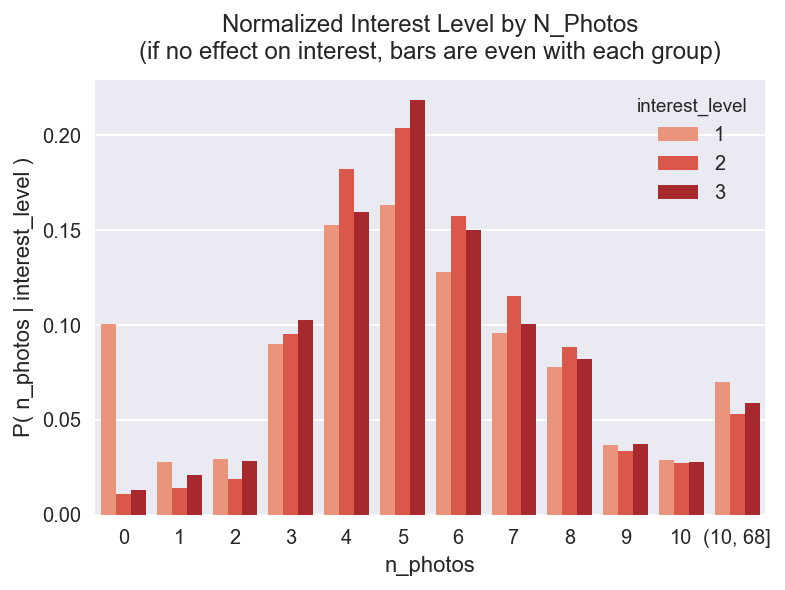

In [262]:
# do number of photos affect interest?
x = 'n_photos'
hue = 'interest_level'
data = df.assign(n_photos=df.photos.map(lambda x: len(x)))

bins = list(range(-1, 11)) + [data[x].max()]
ax = plot_prob_x_for_hue(x, data, hue, bins=bins)


ax.set_xticklabels(list(range(11)) + ['(10, 68]'], rotation=0)

# plt.savefig(''.join([REPORT_IMG_DIR, '7-n-photos-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Number of Features

n_feats chi2 p-val = 0.0000 (rounded)


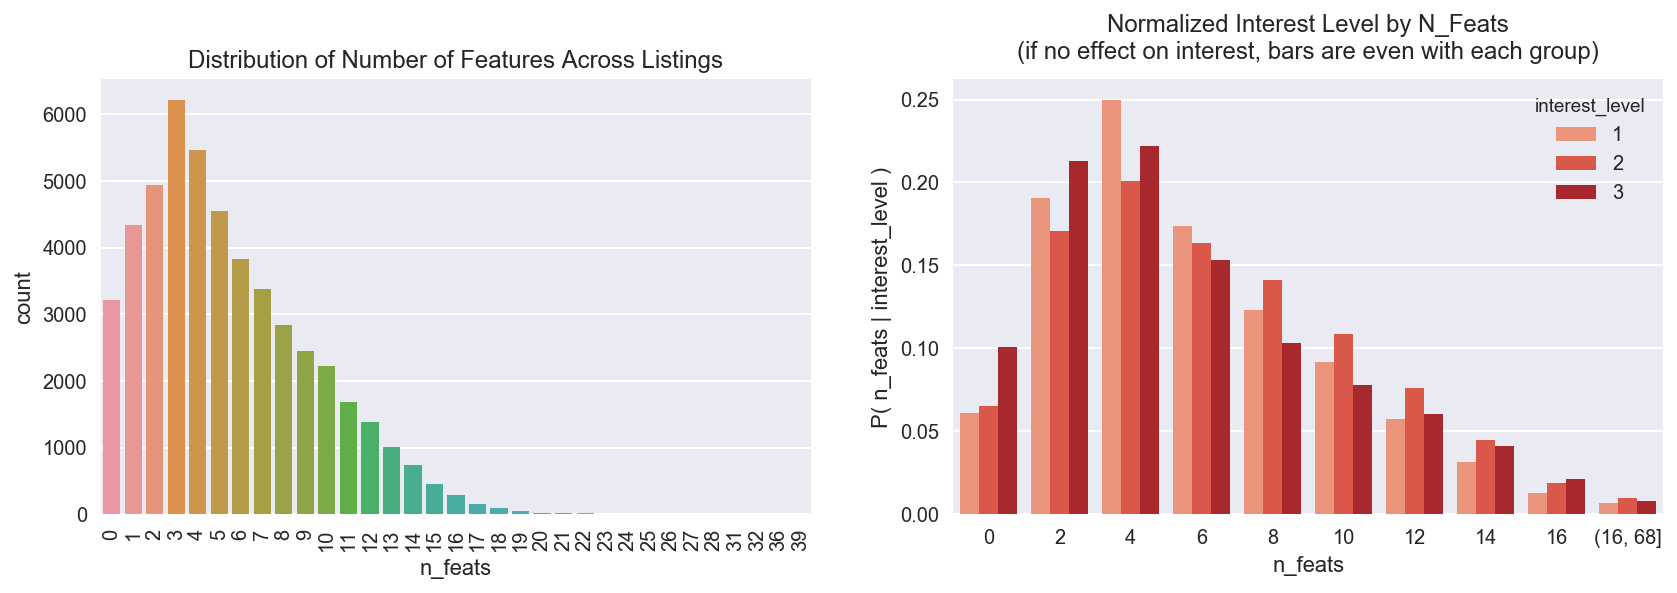

In [277]:
# do number of features affect interest?
data = df.assign(n_feats=df.features.apply(lambda x: len(x)))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

sns.countplot(data.n_feats, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Distribution of Number of Features Across Listings')

x = 'n_feats'
hue = 'interest_level'
bins = [-1] + list(range(0, 17, 2)) + [data[x].max()]
plot_prob_x_for_hue(x, data, hue, bins, ax=ax2)

ax2.set_xticklabels(list(range(0, 17, 2)) + ['(16, 68]'], rotation=0)

# plt.savefig(''.join([REPORT_IMG_DIR, '8-n-feats-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Description Word Count

descr_wcnt chi2 p-val = 0.0000 (rounded)


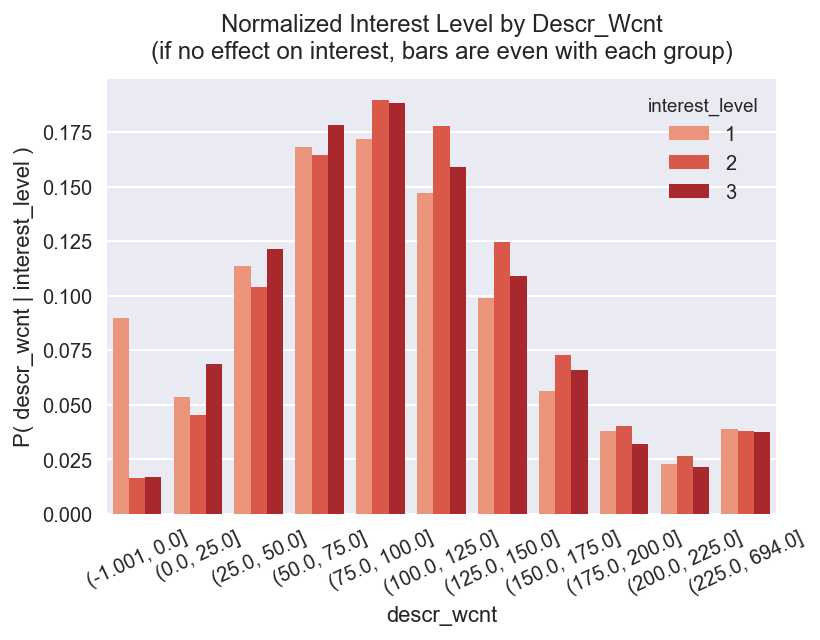

In [278]:
# does length of description affect interest?
data = df.assign(descr_wcnt=df.description.apply(get_word_cnt))
x = 'descr_wcnt'
hue = 'interest_level'

bins = [-1] + list(range(0, 226, 25)) + [data.descr_wcnt.max()]
plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins)

plt.xticks(rotation=25)

# plt.savefig(''.join([REPORT_IMG_DIR, '9-descrip-wcnt-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

### Scaling of count features

In [70]:
scl_len_mapper = DataFrameMapper([
    ('photos', [LenExtractor(), StandardScaler()],
         {'alias': 'n_photos'}),
    ('features', [LenExtractor(), SqrtTransformer(), StandardScaler()],
         {'alias': 'n_feats'}),
    ('description', [WordCntExtractor(), SqrtTransformer(), StandardScaler()],
         {'alias': 'descr_wcnt'}),
], input_df=True, df_out=True)


data = scl_len_mapper.fit_transform(df)

fig, axs = plt.subplots(nrows=3, figsize=(5, 10))

for (_, ser), ax in zip(data.items(), axs):
    sns.distplot(ser, ax=ax)

/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Manager Activity and Performance

- Total posts
- Posts/duration
- Rating/post

In [3]:
df = read_rental_interest(DF_TRAIN_PKL)

n_posts chi2 p-val = 0.0000 (rounded)


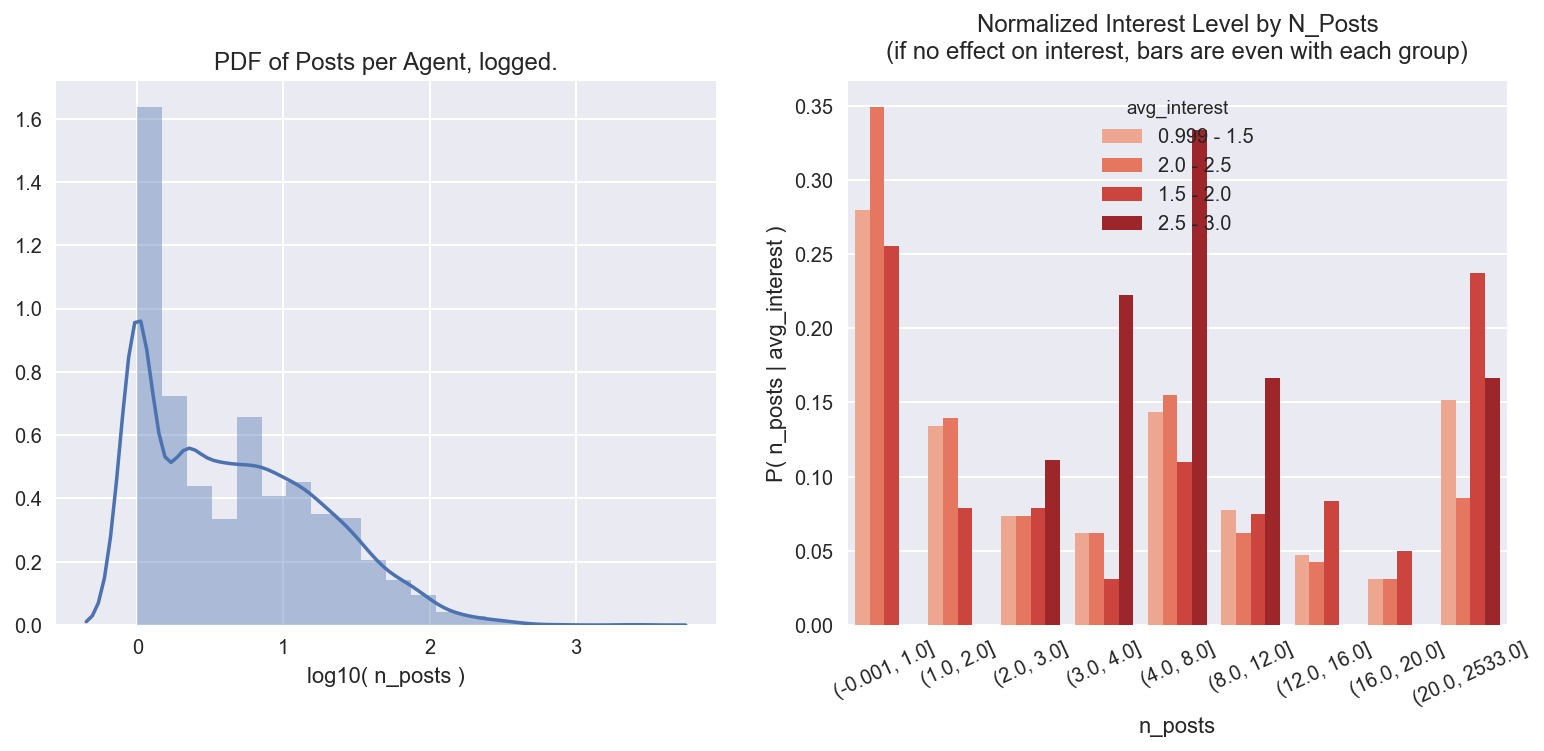

In [321]:
# see if activity of agents affects interest

prior = df.interest_level.mean()
avg_int = (df.groupby('manager_id')['interest_level']
#            .apply(exp_int, prior)
           .mean()
           .rename('avg_interest')
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
n_posts = df.manager_id.value_counts().rename('n_posts')

ax1 = sns.distplot(np.log10(n_posts), bins=20, ax=ax1)

ax1.set_xlabel('log10( n_posts )')
ax1.set_title('PDF of Posts per Agent, logged.')

data = pd.concat([n_posts, avg_int], axis=1)
x = 'n_posts'
hue = 'avg_interest'

bins = [0, 1, 2, 3] + list(range(4, 24, 4)) + [data.n_posts.max()]
hue_bins = [1, 1.5, 2, 2.5, 3]
ax2= plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins,
                          hue_bins=hue_bins, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25)

# plt.savefig(''.join([REPORT_IMG_DIR, '10-n-posts-on-avg-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Building Activity and Performance

#### Listing counts by building (i.e. building activity)

In [124]:
df.query("building_id != '0'").shape

(41066, 14)

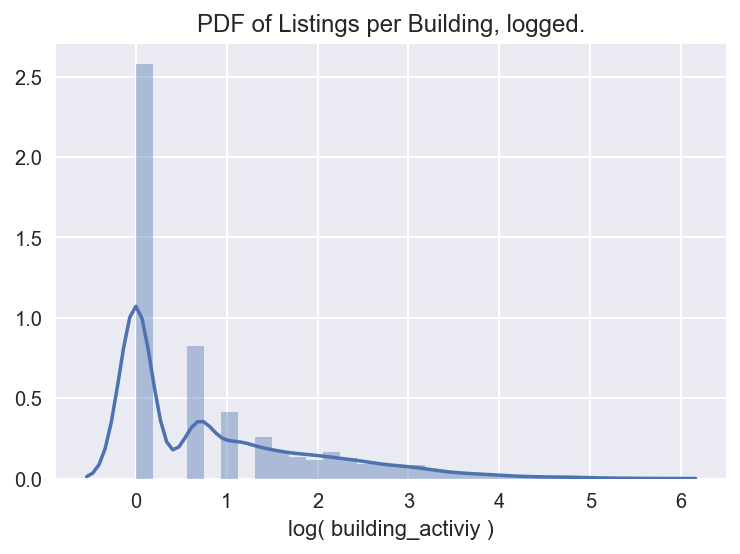

In [130]:
building_activiy = (df.query("building_id != '0'")
                      .building_id.value_counts()
                      .rename('building_activiy')
)

sns.distplot(np.log(building_activiy), bins=30)
plt.xlabel('log( building_activiy )')
plt.title('PDF of Listings per Building, logged.')

In [322]:
a, b = 4+4, 3

In [133]:
data.building_activiy.max()

2533.0

In [178]:
# see if activity of agents affects interest

prior = df.groupby('building_id')['interest_level'].mean().mean()
avg_int = (df.groupby('building_id')['interest_level']
             .apply(exp_int, prior)
             .rename('avg_interest')
)

building_activiy = df.manager_id.value_counts().rename('building_activiy')
data = pd.concat([building_activiy, avg_int], axis=1)

bins = [0, 1, 2, 3, 4, 6, 8, 12, 16, 25, 30, data.building_activiy.max()]

x = 'building_activiy'
hue = 'avg_interest'

hue_bins = [1, 1.5, 2, 2.5, 3]

plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins, hue_bins=hue_bins)

# plt.savefig(''.join([REPORT_IMG_DIR, '11-building-act-on-avg-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

ValueError: Some hue values fall outside bins.

## Feature Importance

In [25]:
start_mapper.fit_transform(df).head()

,bathrooms_bedrooms_latitude_longitude_price_0,bathrooms_bedrooms_latitude_longitude_price_1,bathrooms_bedrooms_latitude_longitude_price_2,bathrooms_bedrooms_latitude_longitude_price_3,bathrooms_bedrooms_latitude_longitude_price_4
0,1.50000,3.00000,40.71450,-73.94250,3000.00000
1,1.00000,2.00000,40.79470,-73.96670,5465.00000
2,1.00000,1.00000,40.73880,-74.00180,2850.00000
3,1.00000,1.00000,40.75390,-73.96770,3275.00000
4,1.00000,4.00000,40.82410,-73.94930,3350.00000


In [35]:
from datamap_pipe import *

In [27]:
# extractor_map = DataFrameMapper([
#     (['bathrooms'], None),
#     (['bedrooms'],  None),
#     (['latitude'],  None),
#     (['longitude'], None),
#     (['price'],     None),
    
#     ('photos', LenExtractor(),
#          {'alias': 'n_photos'}),
#     ('features', LenExtractor(),
#          {'alias': 'n_feats'}),
#     ('description', WordCntExtractor(),
#          {'alias': 'descr_wcnt'}),
    
#     ('manager_id', GroupSumExtractor(),
#          {'alias': 'n_posts'}),
#     ('building_id', GroupSumExtractor(),
#          {'alias': 'n_buildings'}),
    
# #     ('created', DayExtractor()),
    
# ], input_df=True, df_out=True)

# scaler_map = DataFrameMapper([
#     (['bathrooms'], StandardScaler()),
#     (['bedrooms'], StandardScaler()),
#     (['latitude'], StandardScaler()),
#     (['longitude'], StandardScaler()),
#     (['price'], [LogTransformer(), StandardScaler()]),
#     ('n_photos', [SqrtTransformer(), StandardScaler()]),
#     ('n_feats', [SqrtTransformer(), StandardScaler()]),
#     ('descr_wcnt', [SqrtTransformer(), StandardScaler()]),
#     ('manager_id', [LogTransformer(), StandardScaler()],
#          {'alias': 'n_posts'}),
#     ('building_id', [LogTransformer(), StandardScaler()],
#          {'alias': 'n_buildings'}),
# ], input_df=True, df_out=True, default=None)


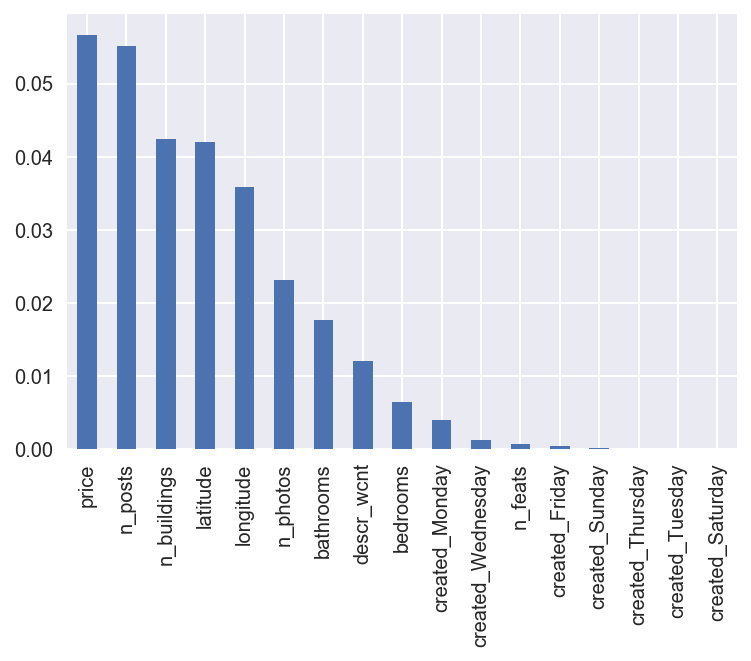

In [12]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X = pipe.fit_transform(X)

discrete_features = [5]  # for boolean is_weekend
info = mutual_info_classif(X, y, discrete_features=discrete_features,
                           random_state=SEED)
mi = pd.Series(info, index=X.columns).sort_values(ascending=False)
mi.plot('bar')

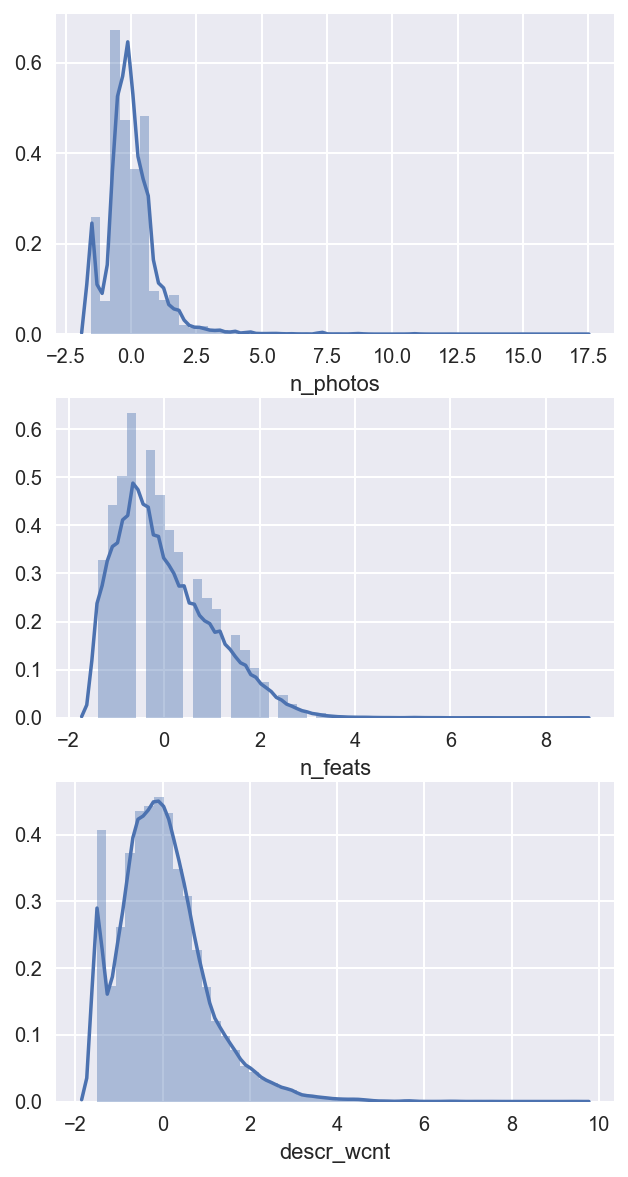

In [64]:
fig, axs = plt.subplots(nrows=3, figsize=(5, 10))

for (_, ser), ax in zip(data.items(), axs):
    sns.distplot(ser, ax=ax)

In [ ]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=SEED)
forest.fit(X, y)


arr = np.vstack([tree.feature_importances_ for tree in forest.estimators_])
data = pd.DataFrame(arr, columns=X.columns)
data = data.reindex(columns=data.mean().sort_values(ascending=False).index)


sns.barplot(data=data)
plt.title('Feature importances')
plt.xticks(rotation=75)
plt.show()

## PCA

['40.231%', '22.645%', '13.452%', '8.416%', '7.235%', '5.147%', '2.874%']


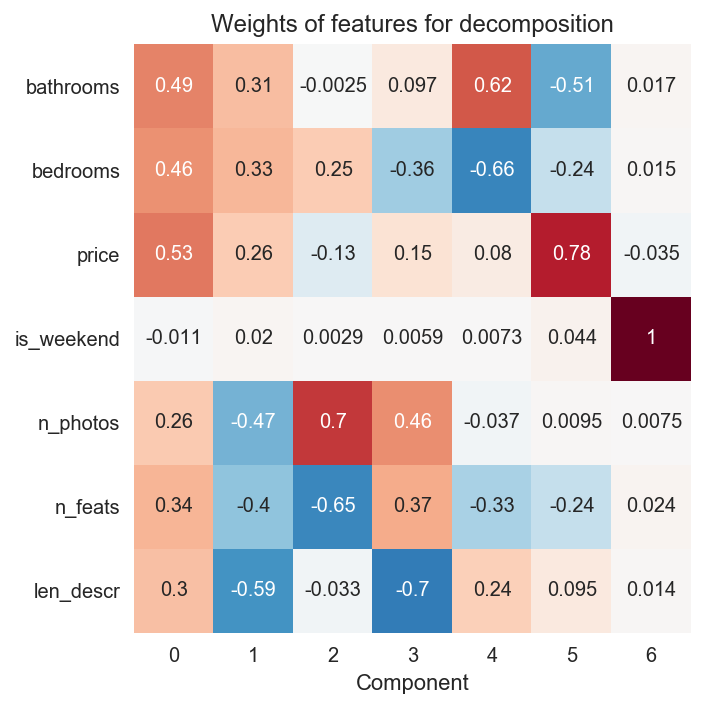

In [18]:
a_mapper = combine_mappers(
    [scl_base_mapper, date_mapper, scl_len_mapper]
)

a_pipe = Pipeline([
    ('bb_imputer', BedBathImputer()),
    ('ll_imputer', LatLongImputer()),
    ('a_mapper', a_mapper),
])

X = a_pipe.fit_transform(df).drop(['latitude', 'longitude'], axis=1)

reducer = PCA(n_components=7)

reduced = reducer.fit_transform(X)
explained_variance = reducer.explained_variance_ratio_
print(['{:.3%}'.format(x) for x in explained_variance])

plt.figure(figsize=(5, 5))
sns.heatmap(reducer.components_.T, yticklabels=X.columns.tolist(),
            cbar=False, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

In [326]:
from scipy.cluster import hierarchy

ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(X, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

NameError: name 'X' is not defined

In [35]:
from hdbscan import HDBSCAN


clusterer = HDBSCAN().fit(X)

In [36]:
two_d = reduced[:, :2]

with sns.axes_style('white'):
    sns.lmplot(*two_d.T, hue=clusterer.labels_,
                scatter_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.show()

TypeError: lmplot() missing 1 required positional argument: 'data'

# Learning

## Notes

__About the target variable__:
- From Kaggle: "The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site."
- This means listings taken down quickly due to a quick close will be classified with the same interest level as one that takes longer to close and has the same number of inquiries.
- If we take a more holistic approach to interest level, another distortion could arise with listings that have lots of inquiries due to listings that are higher quality relative to the actual property.
- Ultimately, the distorting factor of duration is unknown because, assuming the listing were shown as they are now, the search ranking is determined not only by "freshness" but also by the quality of the posting and the property itself (possibly derived from interest level). 

__Dealing with class imbalance__:
- High: 0.078, medium: 0.228, low: 0.695
- https://stats.stackexchange.com/questions/122409/why-downsample
- For probabilistic models, we need that informatation of the imbalance!
- If balance, logloss worse than benchmark

__Logistic Regression__
- Cost function favors majority class, but so does the class distribution!
- ~~`Sklearn` implementation has `weight` parameter with `balanced` option.~~

__Dealing with outliers__:
- Examine with HDBSCAN
- Look at classes of outliers

__Logistic Regression__:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- `Liblinear` only compatible with `ovr`, use others for `multinomial`
- For build-in CV for regularization strength, use: [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

__Gradient boosted trees__:
- 

Stochastic Gradient Descent with modified huber loss:
- using sklearn's [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- `modified_huber` is another smooth loss that brings tolerance to outliers as well as probability estimates

__Train test split__

- 

## Spot-check algorithms

Random guessing score:

In [8]:
df = read_rental_interest(DF_TRAIN_PKL)
y = LabelBinarizer().fit_transform(df.interest_level)

avg_probs = (np.sum(y, axis=0)/len(y)).tolist()
baseline_pred = np.array(avg_probs*len(y)).reshape(-1, 3)
baseline_score = log_loss(y, baseline_pred)
baseline_score

0.78857691143225461

### Spot-check

In [70]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.35, random_state=SEED, stratify=y)

### Algorithm: Logistic Regression

In [15]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.35, random_state=SEED, stratify=y)

X_train = scl_pipe.fit_transform(X_train)
X_test = scl_pipe.transform(X_test)

In [205]:
# booleans, no way to intergrate bool_mapper into one Pipeline/FeatureUnion
def make_boolean_cols(df):
    df = df.copy()
    # Use min for zero value of standardized data
    df['no_photo'] = df.n_photos == 0
    df['no_feats'] = df.n_feats == 0
    df['no_desc'] = df.len_descr == 0
    df['one_post'] = df.n_posts == 0
    
    return df

X_train = make_boolean_cols(X_train)
X_test = make_boolean_cols(X_test)

In [44]:
scl = scaler
scl = StandardScaler()

clf = LogisticRegression(random_state=SEED, multi_class='multinomial',
                         warm_start=True, max_iter=1000)

pipe = Pipeline([
    ('ll_imputer', LatLongImputer(imp_val=False)),
    ('bb_imputer', BedBathImputer()),
    ('extractor', extractor),
    ('scaler', scl),
    ('clf', clf),
])

parameters = dict(
    clf__C=np.logspace(-4, 4, 10),
    clf__solver=['newton-cg', 'lbfgs', 'sag'],
)


grid = GridSearchCV(pipe, parameters, n_jobs=-1, scoring=scoring,
                    error_score=np.nan)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid.fit(X_train, y_train)

print(best_grid_results(grid))

KeyError: 'photos'

In [19]:
grid.best_estimator_.coef_


Train score:   -0.66106
Test score :   -0.66246


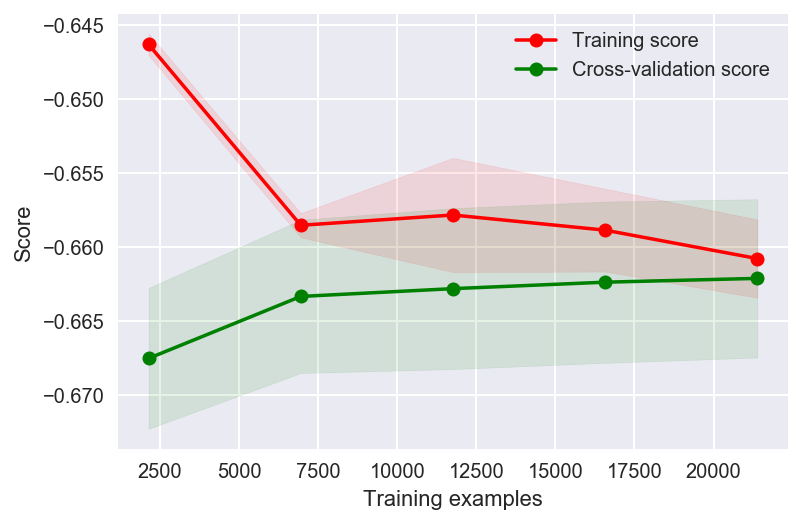

In [207]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))

plot_learning_curve(clf,
                    X_train, y_train,
                    scoring=scoring,
                    n_jobs=-1);

3.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


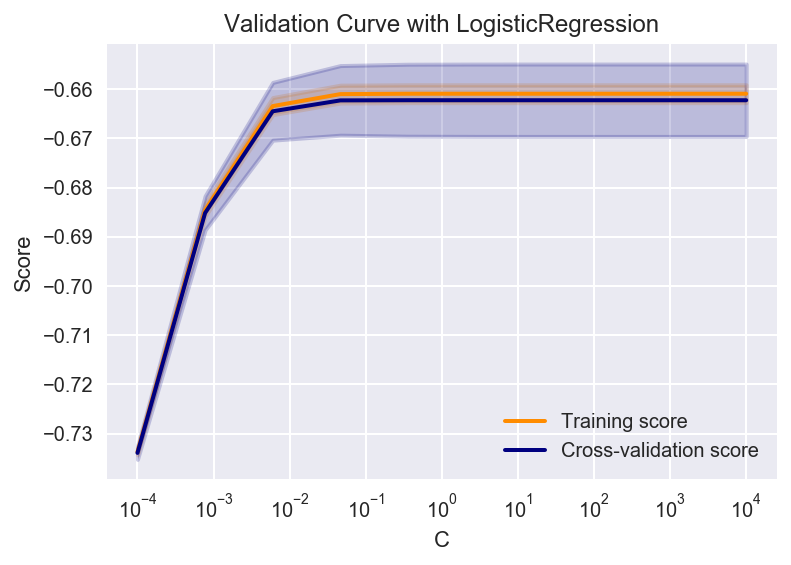

In [112]:
clf = grid.best_estimator_

kwargs = dict(estimator=clf, X=X_train, y=y_train,
              param_name='C', param_range=np.logspace(-4, 4, 10),
              scoring=scoring, cv=5, n_jobs=-1)
%timeit -r1 -n1 plot_validation_curve(**kwargs).set_xscale('log');

### Algorithm: `KNeighborsClassifier`

In [83]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.35, random_state=SEED, stratify=y)

mapper = mapper.fit(X_train)

X_train = mapper.transform(X_train)
X_test = mapper.transform(X_test)

In [84]:
N_COMP = 6

pca = PCA(random_state=SEED).fit(X_train)
X_train_pca = pca.transform(X_train)[:, :N_COMP]
X_test_pca  = pca.transform(X_test)[:, :N_COMP]

parameters = dict(
    n_neighbors=[100, 200, 300, 400, 600],
)
clf = KNeighborsClassifier(n_jobs=1)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring,
                    error_score=np.nan)

# Errors in calculating logloss should be ignored
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    %timeit -r1 -n1 grid.fit(X_train_pca, y_train)

print()
print(best_grid_results(grid))

23.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best score: -0.71147

*** For parameters: ***
n_neighbors: 300


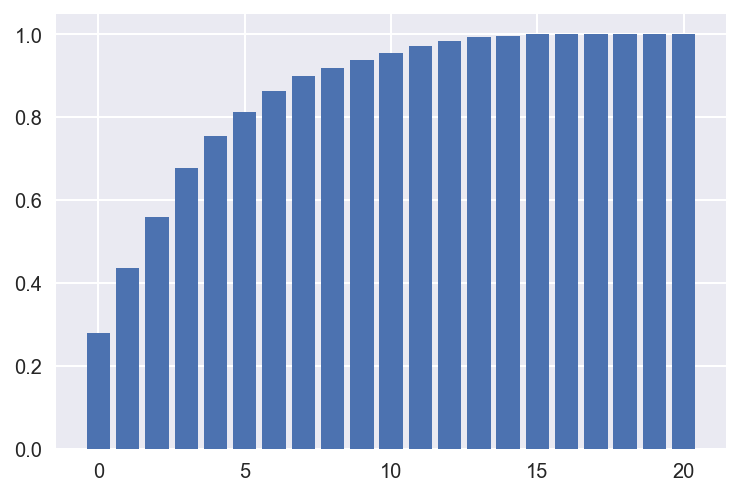

In [77]:
pca = PCA(random_state=SEED).fit(X_train)
comps = pca.explained_variance_ratio_
plt.bar(range(len(comps)), np.cumsum(comps));

In [85]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train_pca)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test_pca)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))

Train score:   -0.70109
Test score :   -0.70972


### Algorithm: `GradientBoostingClassifier`

In [86]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.35, random_state=SEED, stratify=y)

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [94]:
parameters = dict(
    min_samples_split=[2, 6],
    max_depth=[3, 4],
)

clf = GradientBoostingClassifier(random_state=SEED)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring)
%timeit -r1 -n1 grid.fit(X_train, y_train)

print()
print(best_grid_results(grid))

27.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best score: -0.60825

*** For parameters: ***
max_depth: 4
min_samples_split: 6


Train score:    0.55997
Test score :    0.60984

31.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


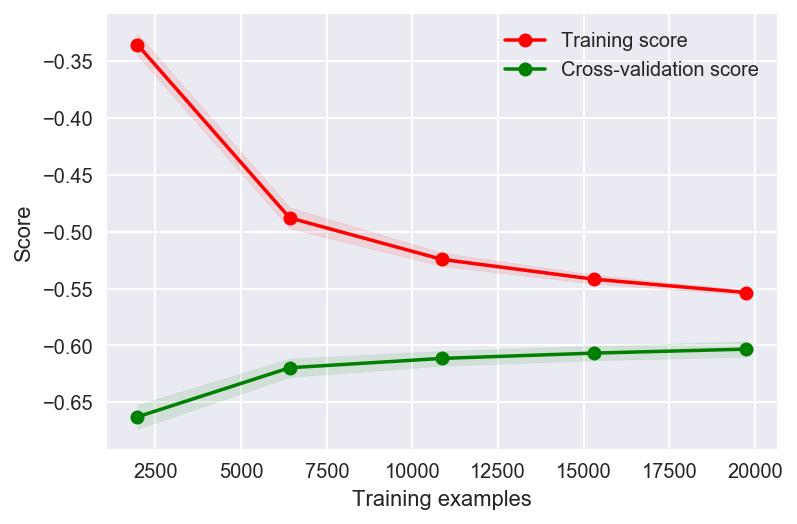

In [79]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))
print()

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # so timeit works
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

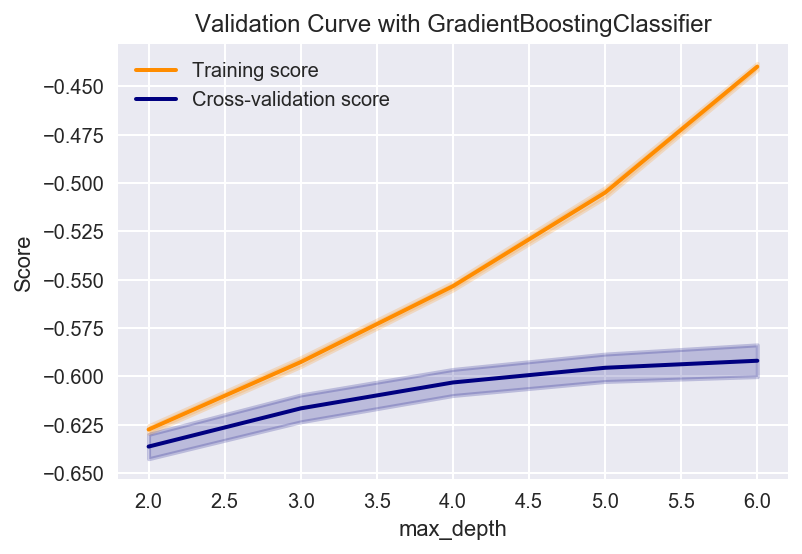

1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


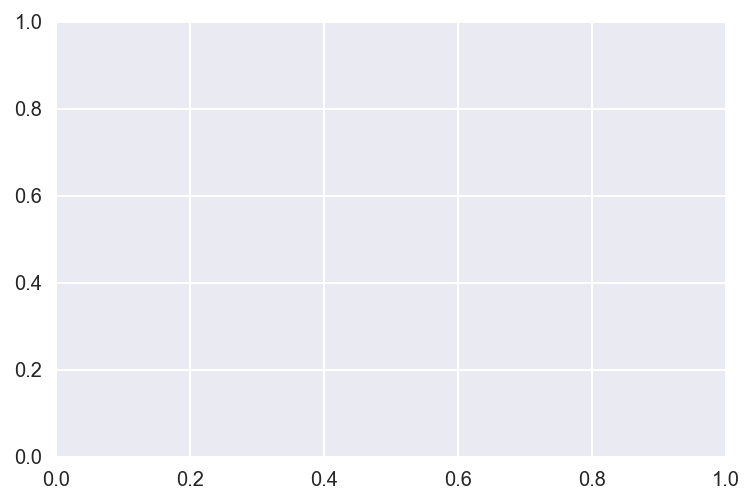

In [96]:
clf = grid.best_estimator_

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  param_name='max_depth', param_range = [2, 3, 4, 5, 6],
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_validation_curve(**kwargs)

### Algorithm: `XGBoost`

- For trees, no scaling or booleans necessary

In [4]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level



# X_train = pipe.fit_transform(X_train)
# X_test = pipe.transform(X_test)

- bools not necessary with tree, covered with variable that they are derived from
- man_avg and man_exp used (not just man_exp)
- No standardization or scaling necessary

WHY ARE SOME FEATURES DROPPED? (like bools and avg/exp, detailed explanation)
- Leaves out less important one?

In [5]:
from preprocessing import *

In [1]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.35, random_state=SEED, stratify=y)


feature_mapper = DataFrameMapper([
    (['bathrooms'], None),
    (['bedrooms'],  None),
    (['latitude'],  None),
    (['longitude'], None),
    (['price'],     None),
    
#     ('photos', [LenExtractor()],
#          {'alias': 'n_photos'}),
#     ('features', [LenExtractor()],
#          {'alias': 'n_feats'}),
#     ('description', [WordCntExtractor()],
#          {'alias': 'descr_wcnt'}),
    
#     ('manager_id', [GroupSumExtractor()],
#          {'alias': 'n_posts'}),
#     ('building_id', [GroupSumExtractor()],
#          {'alias': 'n_buildings'}),
], input_df=True, df_out=False)

xgb_clf = xgb.XGBClassifier(objective='multi:softprob', silent=1,
                            nthread=1, seed=SEED, missing=-999)

clf_p = Pipeline([
    ('bb_imputer', BedBathImputer(imp_val=-999)),
    ('ll_imputer', LatLongImputer(imp_val=-999)),
    ('scale_aggr', feature_mapper),
    ('xgb_clf', 
         xgb.XGBClassifier(objective='multi:softprob', silent=1,
         nthread=1, seed=SEED, missing=-999)
    )
])

parameters = dict(
    bb_imputer__imp_val=[-999, False],
    ll_imputer__imp_val=[-999, False],
)

grid = GridSearchCV(clf_p, parameters, n_jobs=-1, scoring=scoring)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    %timeit -r1 -n1 grid.fit(X_train, y_train)

print()
print(best_grid_results(grid))


clf = grid.best_estimator_

NameError: name 'train_test_split' is not defined

In [9]:
y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))
print()

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # so timeit works
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=cv, scoring=scoring, n_jobs=1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

JoblibKeyError: JoblibKeyError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x1027f31e0, file "/Use...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/mdlynch37/anaconda3/envs/rental-interest/...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/mdlyn.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1027f31e0, file "/Use...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/mdlynch37/anaconda3/envs/rental-interest/...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/mdlyn.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'X_train, X_test, y_train, y_test = train_test_sp...    %timeit -r1 -n1 plot_learning_curve(**kwargs)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 20, 6, 32, 5, 187338, tzinfo=datetime.timezone.utc), 'msg_id': 'A96933E9194D44F98B3DB5B31CE46B2D', 'msg_type': 'execute_request', 'session': '70009222E76143AB9065645EE10D7ED3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A96933E9194D44F98B3DB5B31CE46B2D', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'70009222E76143AB9065645EE10D7ED3']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'X_train, X_test, y_train, y_test = train_test_sp...    %timeit -r1 -n1 plot_learning_curve(**kwargs)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 20, 6, 32, 5, 187338, tzinfo=datetime.timezone.utc), 'msg_id': 'A96933E9194D44F98B3DB5B31CE46B2D', 'msg_type': 'execute_request', 'session': '70009222E76143AB9065645EE10D7ED3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A96933E9194D44F98B3DB5B31CE46B2D', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'70009222E76143AB9065645EE10D7ED3'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'X_train, X_test, y_train, y_test = train_test_sp...    %timeit -r1 -n1 plot_learning_curve(**kwargs)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 20, 6, 32, 5, 187338, tzinfo=datetime.timezone.utc), 'msg_id': 'A96933E9194D44F98B3DB5B31CE46B2D', 'msg_type': 'execute_request', 'session': '70009222E76143AB9065645EE10D7ED3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A96933E9194D44F98B3DB5B31CE46B2D', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='X_train, X_test, y_train, y_test = train_test_sp...    %timeit -r1 -n1 plot_learning_curve(**kwargs)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'X_train, X_test, y_train, y_test = train_test_sp...    %timeit -r1 -n1 plot_learning_curve(**kwargs)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('X_train, X_test, y_train, y_test = train_test_sp...    %timeit -r1 -n1 plot_learning_curve(**kwargs)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('X_train, X_test, y_train, y_test = train_test_sp...    %timeit -r1 -n1 plot_learning_curve(**kwargs)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='X_train, X_test, y_train, y_test = train_test_sp...    %timeit -r1 -n1 plot_learning_curve(**kwargs)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.With object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.With object>], cell_name='<ipython-input-9-f08ca2733827>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1043794a8, execution_..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11c312810, file "<ipython-input-9-f08ca2733827>", line 45>
        result = <ExecutionResult object at 1043794a8, execution_..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11c312810, file "<ipython-input-9-f08ca2733827>", line 45>, result=<ExecutionResult object at 1043794a8, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11c312810, file "<ipython-input-9-f08ca2733827>", line 45>
        self.user_global_ns = {'AverageInterestExtractor': <class 'preprocessing.AverageInterestExtractor'>, 'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BedBathImputer': <class 'preprocessing.BedBathImputer'>, 'BoolFlagTransformer': <class 'preprocessing.BoolFlagTransformer'>, 'DAT_DIR': '../Data/', 'DF_TEST_PKL': '../Data/df_test.pkl', 'DF_TRAIN_PKL': '../Data/df_train.pkl', 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'DayExtractor': <class 'preprocessing.DayExtractor'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, ...}
        self.user_ns = {'AverageInterestExtractor': <class 'preprocessing.AverageInterestExtractor'>, 'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BedBathImputer': <class 'preprocessing.BedBathImputer'>, 'BoolFlagTransformer': <class 'preprocessing.BoolFlagTransformer'>, 'DAT_DIR': '../Data/', 'DF_TEST_PKL': '../Data/df_test.pkl', 'DF_TRAIN_PKL': '../Data/df_train.pkl', 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'DayExtractor': <class 'preprocessing.DayExtractor'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/mdlynch37/projects/kaggle/rental-interest/Executable/<ipython-input-9-f08ca2733827> in <module>()
     42 
     43 grid = GridSearchCV(clf_p, parameters, n_jobs=-1, scoring=scoring)
     44 
     45 with warnings.catch_warnings():
     46     warnings.simplefilter('ignore')
---> 47     get_ipython().magic('timeit -r1 -n1 grid.fit(X_train, y_train)')
     48 
     49 print()
     50 print(best_grid_results(grid))
     51 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/core/interactiveshell.py in magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, arg_s='timeit -r1 -n1 grid.fit(X_train, y_train)')
   2141         compound statements.
   2142         """
   2143         # TODO: should we issue a loud deprecation warning here?
   2144         magic_name, _, magic_arg_s = arg_s.partition(' ')
   2145         magic_name = magic_name.lstrip(prefilter.ESC_MAGIC)
-> 2146         return self.run_line_magic(magic_name, magic_arg_s)
        self.run_line_magic = <bound method InteractiveShell.run_line_magic of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        magic_name = 'timeit'
        magic_arg_s = '-r1 -n1 grid.fit(X_train, y_train)'
   2147 
   2148     #-------------------------------------------------------------------------
   2149     # Things related to macros
   2150     #-------------------------------------------------------------------------

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_line_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='timeit', line='-r1 -n1 grid.fit(X_train, y_train)')
   2062             kwargs = {}
   2063             # Grab local namespace if we need it:
   2064             if getattr(fn, "needs_local_scope", False):
   2065                 kwargs['local_ns'] = sys._getframe(stack_depth).f_locals
   2066             with self.builtin_trap:
-> 2067                 result = fn(*args,**kwargs)
        result = undefined
        fn = <bound method ExecutionMagics.timeit of <IPython.core.magics.execution.ExecutionMagics object>>
        args = ['-r1 -n1 grid.fit(X_train, y_train)']
        kwargs = {}
   2068             return result
   2069 
   2070     def run_cell_magic(self, magic_name, line, cell):
   2071         """Execute the given cell magic.

...........................................................................
/Users/mdlynch37/projects/kaggle/rental-interest/Executable/<decorator-gen-61> in timeit(self=<IPython.core.magics.execution.ExecutionMagics object>, line='-r1 -n1 grid.fit(X_train, y_train)', cell=None)
      1 
----> 2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.timeit>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '-r1 -n1 grid.fit(X_train, y_train)', None), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.timeit>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '-r1 -n1 grid.fit(X_train, y_train)', None)
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/core/magics/execution.py in timeit(self=<IPython.core.magics.execution.ExecutionMagics object>, line='-r1 -n1 grid.fit(X_train, y_train)', cell=None)
   1079                 number = 10 ** index
   1080                 time_number = timer.timeit(number)
   1081                 if time_number >= 0.2:
   1082                     break
   1083 
-> 1084         all_runs = timer.repeat(repeat, number)
        all_runs = undefined
        timer.repeat = <bound method Timer.repeat of <IPython.core.magics.execution.Timer object>>
        repeat = 1
        number = 1
   1085         best = min(all_runs) / number
   1086         worst = max(all_runs) / number
   1087         timeit_result = TimeitResult(number, repeat, best, worst, all_runs, tc, precision)
   1088 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/timeit.py in repeat(self=<IPython.core.magics.execution.Timer object>, repeat=1, number=1)
    201         interested in.  After that, you should look at the entire
    202         vector and apply common sense rather than statistics.
    203         """
    204         r = []
    205         for i in range(repeat):
--> 206             t = self.timeit(number)
        t = undefined
        self.timeit = <bound method Timer.timeit of <IPython.core.magics.execution.Timer object>>
        number = 1
    207             r.append(t)
    208         return r
    209 
    210 def timeit(stmt="pass", setup="pass", timer=default_timer,

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/core/magics/execution.py in timeit(self=<IPython.core.magics.execution.Timer object>, number=1)
    155         """
    156         it = itertools.repeat(None, number)
    157         gcold = gc.isenabled()
    158         gc.disable()
    159         try:
--> 160             timing = self.inner(it, self.timer)
        timing = undefined
        self.inner = <function inner>
        it = repeat(None, 0)
        self.timer = <built-in function perf_counter>
    161         finally:
    162             if gcold:
    163                 gc.enable()
    164         return timing

...........................................................................
/Users/mdlynch37/projects/kaggle/rental-interest/Executable/<magic-timeit> in inner(_it=repeat(None, 0), _timer=<built-in function perf_counter>)
    252 
    253 
    254 
    255 
    256 
--> 257 
    258 
    259 
    260 
    261 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...e=True,
       scoring='neg_log_loss', verbose=0), X=            bathrooms  bedrooms                 ...      230 E 30th St.  

[32078 rows x 13 columns], y=listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 32078, dtype: int64, groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...=True,
       scoring='neg_log_loss', verbose=0)>
        X =             bathrooms  bedrooms                 ...      230 E 30th St.  

[32078 rows x 13 columns]
        y = listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 32078, dtype: int64
        groups = None
        self.param_grid = {'bb_imputer__imp_val': [-999, False], 'll_imputer__imp_val': [-999, False]}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=None, error_score='raise',
     ...e=True,
       scoring='neg_log_loss', verbose=0), X=            bathrooms  bedrooms                 ...      230 E 30th St.  

[32078 rows x 13 columns], y=listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 32078, dtype: int64, groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
KeyError                                           Tue Jun 20 02:32:12 2017
PID: 61583Python 3.5.3: /Users/mdlynch37/anaconda3/envs/rental-interest/bin/python
...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(steps=[('bb_imputer', BedBathImputer(im..._pos_weight=1, seed=42, silent=1, subsample=1))]),             bathrooms  bedrooms                 ...      230 E 30th St.  

[32078 rows x 13 columns], listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 32078, dtype: int64, make_scorer(log_loss, greater_is_better=False, needs_proba=True), array([10595, 10596, 10602, ..., 32075, 32076, 32077]), array([    0,     1,     2, ..., 10874, 10881, 10884]), 0, {'bb_imputer__imp_val': False, 'll_imputer__imp_val': -999}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(steps=[('bb_imputer', BedBathImputer(im..._pos_weight=1, seed=42, silent=1, subsample=1))]),             bathrooms  bedrooms                 ...      230 E 30th St.  

[32078 rows x 13 columns], listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 32078, dtype: int64, make_scorer(log_loss, greater_is_better=False, needs_proba=True), array([10595, 10596, 10602, ..., 32075, 32076, 32077]), array([    0,     1,     2, ..., 10874, 10881, 10884]), 0, {'bb_imputer__imp_val': False, 'll_imputer__imp_val': -999})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(steps=[('bb_imputer', BedBathImputer(im..._pos_weight=1, seed=42, silent=1, subsample=1))]), X=            bathrooms  bedrooms                 ...      230 E 30th St.  

[32078 rows x 13 columns], y=listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 32078, dtype: int64, scorer=make_scorer(log_loss, greater_is_better=False, needs_proba=True), train=array([10595, 10596, 10602, ..., 32075, 32076, 32077]), test=array([    0,     1,     2, ..., 10874, 10881, 10884]), verbose=0, parameters={'bb_imputer__imp_val': False, 'll_imputer__imp_val': -999}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = Pipeline(steps=[('bb_imputer', BedBathImputer(im..._pos_weight=1, seed=42, silent=1, subsample=1))])
        X_test =             bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns]
        y_test = listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 10693, dtype: int64
        scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _score(estimator=Pipeline(steps=[('bb_imputer', BedBathImputer(im..._pos_weight=1, seed=42, silent=1, subsample=1))]), X_test=            bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns], y_test=listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 10693, dtype: int64, scorer=make_scorer(log_loss, greater_is_better=False, needs_proba=True))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
        estimator = Pipeline(steps=[('bb_imputer', BedBathImputer(im..._pos_weight=1, seed=42, silent=1, subsample=1))])
        X_test =             bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns]
        y_test = listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 10693, dtype: int64
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(log_loss, greater_is_better=False, needs_proba=True), clf=Pipeline(steps=[('bb_imputer', BedBathImputer(im..._pos_weight=1, seed=42, silent=1, subsample=1))]), X=            bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns], y=listing_id
6969526    1
7007184    3
7152865    ...Name: interest_level, Length: 10693, dtype: int64, sample_weight=None)
    123         score : float
    124             Score function applied to prediction of estimator on X.
    125         """
    126         super(_ProbaScorer, self).__call__(clf, X, y,
    127                                            sample_weight=sample_weight)
--> 128         y_pred = clf.predict_proba(X)
        y_pred = undefined
        clf.predict_proba = <function Pipeline.predict_proba>
        X =             bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns]
    129         if sample_weight is not None:
    130             return self._sign * self._score_func(y, y_pred,
    131                                                  sample_weight=sample_weight,
    132                                                  **self._kwargs)

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/utils/metaestimators.py in <lambda>(*args=(            bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns],), **kwargs={})
     49                     break
     50             else:
     51                 attrgetter(self.delegate_names[-1])(obj)
     52 
     53         # lambda, but not partial, allows help() to work with update_wrapper
---> 54         out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
        args = (            bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns],)
        kwargs = {}
     55         # update the docstring of the returned function
     56         update_wrapper(out, self.fn)
     57         return out
     58 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/pipeline.py in predict_proba(self=Pipeline(steps=[('bb_imputer', BedBathImputer(im..._pos_weight=1, seed=42, silent=1, subsample=1))]), X=            bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns])
    371         y_proba : array-like, shape = [n_samples, n_classes]
    372         """
    373         Xt = X
    374         for name, transform in self.steps[:-1]:
    375             if transform is not None:
--> 376                 Xt = transform.transform(Xt)
        Xt =             bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns]
        transform.transform = <bound method BedBathImputer.transform of BedBathImputer(imp_val=False)>
    377         return self.steps[-1][-1].predict_proba(Xt)
    378 
    379     @if_delegate_has_method(delegate='_final_estimator')
    380     def decision_function(self, X):

...........................................................................
/Users/mdlynch37/projects/kaggle/rental-interest/Executable/preprocessing.py in transform(self=BedBathImputer(imp_val=False), df=            bathrooms  bedrooms                 ... 792 Columbus Avenue  

[10693 rows x 13 columns], y=None)
    257             df.loc[all_miss, 'bathrooms'] = self.bath_med
    258 
    259             gb = df.groupby('bedrooms')
    260             for n_beds, gr_df in gb:
    261                 idx = gr_df.loc[gr_df.bathrooms==0].index
--> 262                 df.loc[idx, 'bathrooms'] = self.grp_bath_med[n_beds]
        df.loc = <pandas.core.indexing._LocIndexer object>
        idx = Int64Index([], dtype='int64', name='listing_id')
        self.grp_bath_med = bedrooms
0   1.00000
1   1.00000
2   1.00000
3  ...00000
7   6.50000
Name: bathrooms, dtype: float64
        n_beds = 8.0
    263         else:
    264             df.loc[all_miss, 'bedrooms'] = self.imp_val
    265             df.loc[only_bath, 'bathrooms'] = self.imp_val
    266 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/pandas/core/series.py in __getitem__(self=bedrooms
0   1.00000
1   1.00000
2   1.00000
3  ...00000
7   6.50000
Name: bathrooms, dtype: float64, key=8.0)
    625 
    626                 # we can try to coerce the indexer (or this will raise)
    627                 new_key = self.index._convert_scalar_indexer(key,
    628                                                              kind='getitem')
    629                 if type(new_key) != type(key):
--> 630                     return self.__getitem__(new_key)
        self.__getitem__ = <bound method Series.__getitem__ of bedrooms
0  ...0000
7   6.50000
Name: bathrooms, dtype: float64>
        new_key = 8
    631                 raise
    632 
    633         except Exception:
    634             raise

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/pandas/core/series.py in __getitem__(self=bedrooms
0   1.00000
1   1.00000
2   1.00000
3  ...00000
7   6.50000
Name: bathrooms, dtype: float64, key=8)
    596         return self._get_values(slobj)
    597 
    598     def __getitem__(self, key):
    599         key = com._apply_if_callable(key, self)
    600         try:
--> 601             result = self.index.get_value(self, key)
        result = undefined
        self.index.get_value = <bound method Index.get_value of Int64Index([0, ... 3, 4, 5, 6, 7], dtype='int64', name='bedrooms')>
        self = bedrooms
0   1.00000
1   1.00000
2   1.00000
3  ...00000
7   6.50000
Name: bathrooms, dtype: float64
        key = 8
    602 
    603             if not is_scalar(result):
    604                 if is_list_like(result) and not isinstance(result, Series):
    605 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/pandas/core/indexes/base.py in get_value(self=Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64', name='bedrooms'), series=bedrooms
0   1.00000
1   1.00000
2   1.00000
3  ...00000
7   6.50000
Name: bathrooms, dtype: float64, key=8)
   2472         k = _values_from_object(key)
   2473 
   2474         k = self._convert_scalar_indexer(k, kind='getitem')
   2475         try:
   2476             return self._engine.get_value(s, k,
-> 2477                                           tz=getattr(series.dtype, 'tz', None))
        series.dtype = dtype('float64')
   2478         except KeyError as e1:
   2479             if len(self) > 0 and self.inferred_type in ['integer', 'boolean']:
   2480                 raise
   2481 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/pandas/_libs/index.cpython-35m-darwin.so in pandas._libs.index.IndexEngine.get_value (pandas/_libs/index.c:4404)()
     93 
     94 
     95 
     96 
     97 
---> 98 
     99 
    100 
    101 
    102 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/pandas/_libs/index.cpython-35m-darwin.so in pandas._libs.index.IndexEngine.get_value (pandas/_libs/index.c:4087)()
    101 
    102 
    103 
    104 
    105 
--> 106 
    107 
    108 
    109 
    110 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/pandas/_libs/index.cpython-35m-darwin.so in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)()
    149 
    150 
    151 
    152 
    153 
--> 154 
    155 
    156 
    157 
    158 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/pandas/_libs/hashtable.cpython-35m-darwin.so in pandas._libs.hashtable.Int64HashTable.get_item (pandas/_libs/hashtable.c:14031)()
    754 
    755 
    756 
    757 
    758 
--> 759 
    760 
    761 
    762 
    763 

...........................................................................
/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/pandas/_libs/hashtable.cpython-35m-darwin.so in pandas._libs.hashtable.Int64HashTable.get_item (pandas/_libs/hashtable.c:13975)()
    760 
    761 
    762 
    763 
    764 
--> 765 
    766 
    767 
    768 
    769 

KeyError: 8
___________________________________________________________________________

In [ ]:
parameters = dict(
    clf__max_depth=[3, 4, 5, 6],
)

clf = xgb.XGBClassifier(objective='multi:softprob', silent=1,
                        nthread=1, seed=SEED, missing=-999)



grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring)
%timeit -r1 -n1 grid.fit(X_train, y_train)

print()
print(best_grid_results(grid))

Train score:    0.51588
Test score :    0.59350

37.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


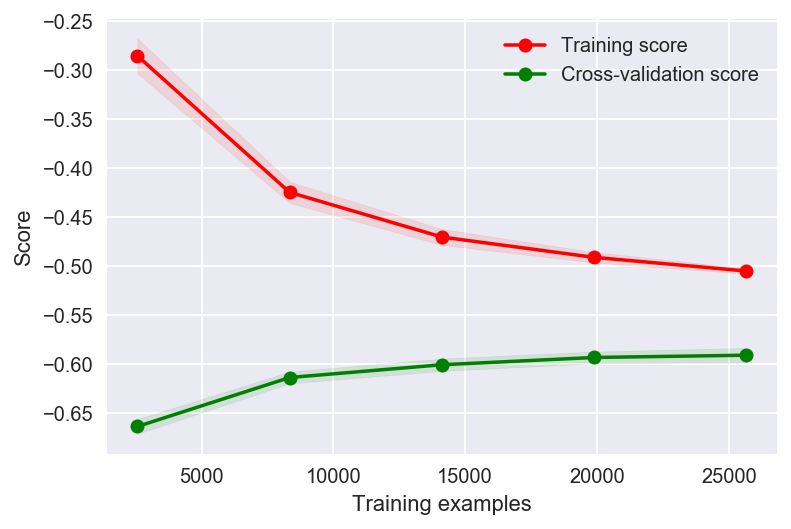

In [122]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))
print()

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # so timeit works
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

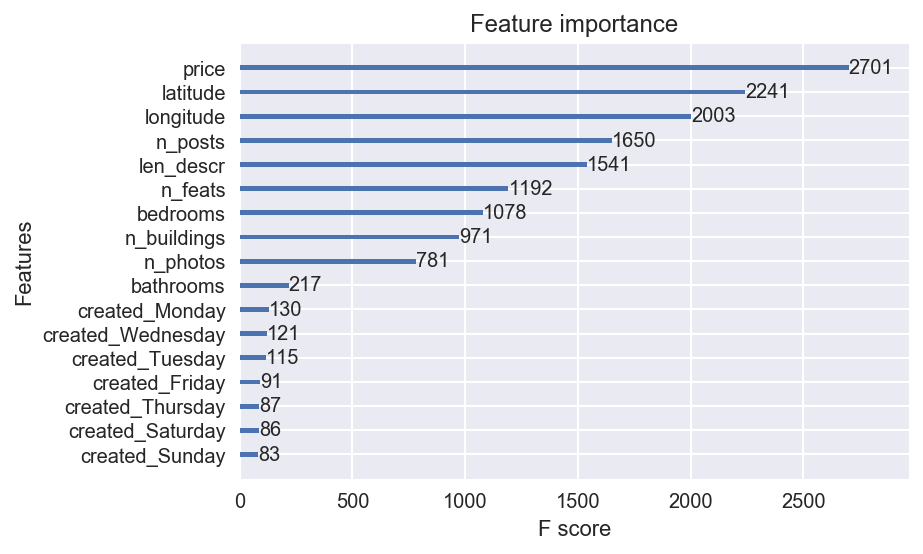

In [32]:
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
xgb.plot_importance(clf.booster())

Train score:    0.51532
Test score :    0.59437

30.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


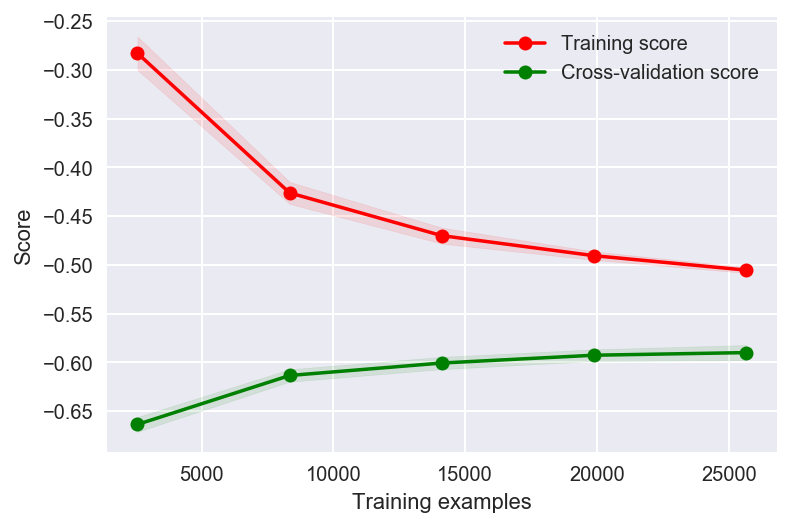

In [31]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))
print()

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # so timeit works
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

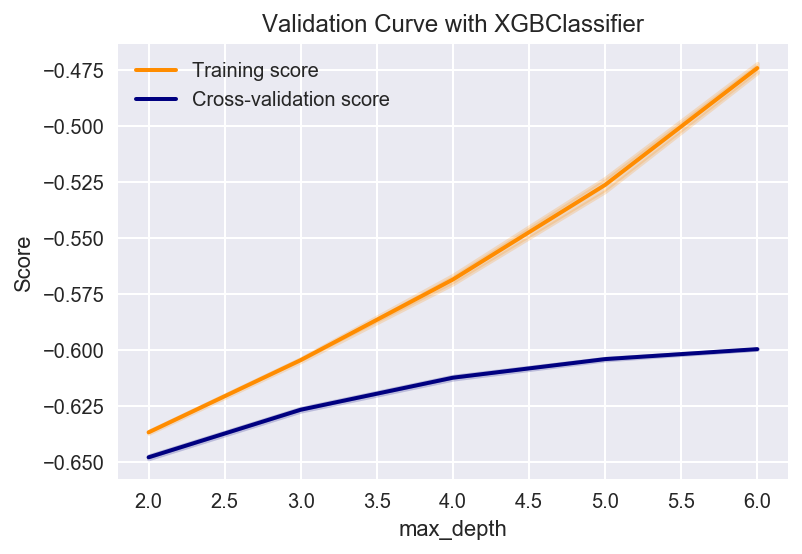

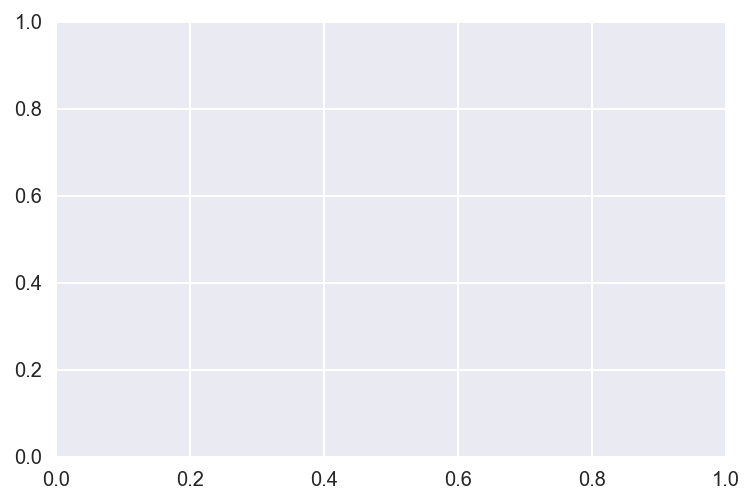

In [40]:
estimator = xgb.XGBClassifier(objective='multi:softprob', silent=0, seed=SEED)
estimator = clf
plot_validation_curve(estimator, X_train, y_train,
                      'max_depth', [2, 3, 4, 5, 6], cv=2, scoring=scoring,
                      n_jobs=-1)
plt.show()

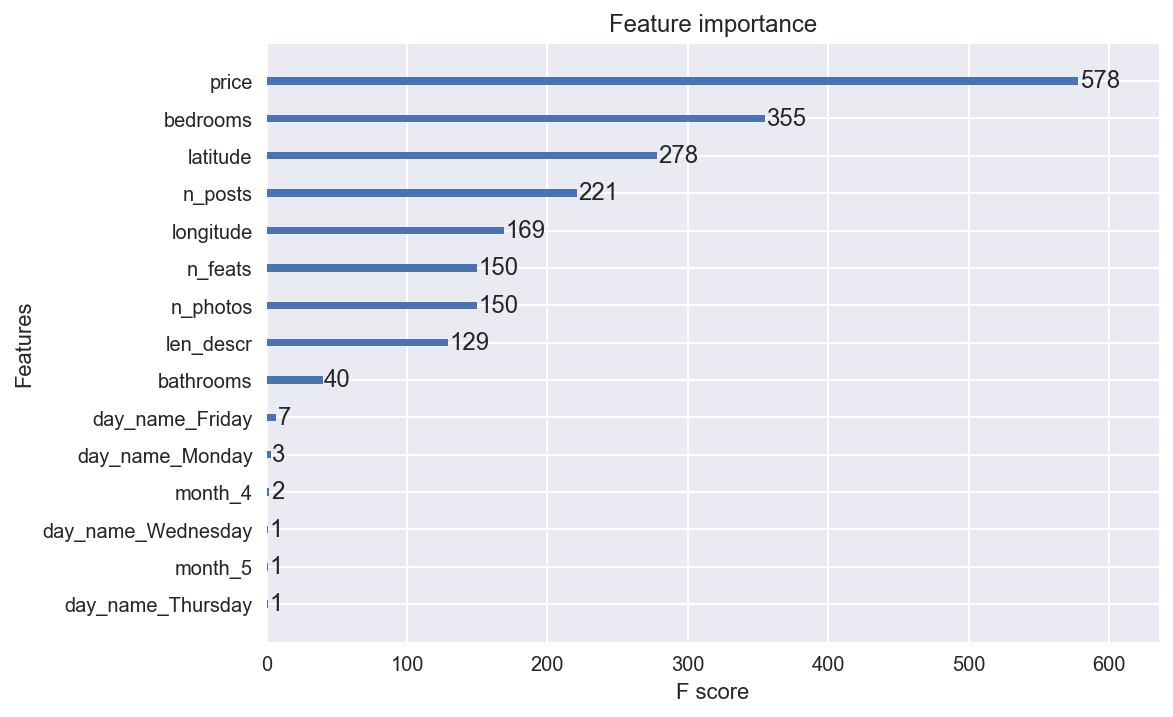

In [267]:
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
xgb.plot_importance(clf.booster())

- Not easy to plot learning or vaidation curve because kernel needs to be restarted after `GridSearch` on `xgboost`. Need to use native cross-validation functions.

In [ ]:
# y_pred = clf.predict_proba(X_train)
# print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

# y_pred = clf.predict_proba(X_test)
# print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_learning_curve(clf,
#                         X_train, y_train,
#                         cv=cv, scoring=scoring,
#                         n_jobs=-1)

In [ ]:
# clf = grid.best_estimator_
# clf = xgb.XGBClassifier(objective='multi:softprob', seed=SEED)

# param_name = 'max_depth'
# param_range = [2, 3, 4, 5, 6]

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_validation_curve(clf, X_train, y_train, param_name, param_range,
#                           cv=cv, scoring=scoring, n_jobs=-1)

## `XGBoost`

In [17]:
import xgboost as xgb

/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
dtest  = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns)

evals  = [(dtest, 'eval'), (dtrain, 'train')]
evals_result = dict()

params = dict(
    max_depth=6,
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=4,
    silent=0, 
)


bst = xgb.train(params, dtrain, num_boost_round=10, evals=evals,
                evals_result=evals_result
)

[0]	eval-mlogloss:1.13509	train-mlogloss:1.13017
[1]	eval-mlogloss:0.992171	train-mlogloss:0.982481
[2]	eval-mlogloss:0.898627	train-mlogloss:0.884873
[3]	eval-mlogloss:0.834232	train-mlogloss:0.816805
[4]	eval-mlogloss:0.790169	train-mlogloss:0.769531
[5]	eval-mlogloss:0.756866	train-mlogloss:0.73304
[6]	eval-mlogloss:0.73144	train-mlogloss:0.705025
[7]	eval-mlogloss:0.711759	train-mlogloss:0.683253
[8]	eval-mlogloss:0.696296	train-mlogloss:0.66434
[9]	eval-mlogloss:0.685253	train-mlogloss:0.650573


In [26]:
params = dict(
    max_depth=6,
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=4,
    silent=0, 
)

xgb.cv(params, dtrain, num_boost_round=10, nfold=5, stratified=True,
       metrics=('mlogloss', 'merror'), seed=SEED)

,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std
0,0.29470,0.00183,1.13554,0.00067,0.28275,0.00111,1.12910,0.00094
1,0.29174,0.00030,0.99237,0.00075,0.28042,0.00135,0.98156,0.00083
2,0.29044,0.00151,0.90003,0.00135,0.27874,0.00143,0.88457,0.00118
3,0.28971,0.00071,0.83550,0.00092,0.27734,0.00092,0.81573,0.00127
4,0.29016,0.00146,0.79071,0.00134,0.27597,0.00053,0.76732,0.00138
5,0.29024,0.00113,0.75767,0.00145,0.27521,0.00059,0.73106,0.00162
6,0.28935,0.00097,0.73248,0.00166,0.27332,0.00145,0.70279,0.00167
7,0.28903,0.00134,0.71292,0.00181,0.27123,0.00197,0.68013,0.00129
8,0.28850,0.00105,0.69822,0.00243,0.26934,0.00155,0.66209,0.00145
9,0.28724,0.00133,0.68604,0.00304,0.26707,0.00086,0.64665,0.00104


## Feature Engineering

In [ ]:
BASIC_FEATURES = ['bathrooms', 'bedrooms', 'price']
TARGET =  ['interest_level']


df = read_rental_interest(DF_TRAIN_PKL)
df_ = df[BASIC_FEATURES+TARGET]

X = df.drop('interest_level', axis=1)

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.2, stratify=y)
    )

X_train.shape

In [ ]:
np.bincount(y)

### Feature lists

#### Explore

In [ ]:
n_feats = df.features.map(lambda x: len(x))
plt.hist(n_feats, cumulative=True, normed=True, bins=300, align='left')
plt.title('CDF of number of features for each listing.')
print('min: {} (n={})\nmed: {}\nmax: {}'.format(
    n_feats.min(), (n_feats==0).sum(),
    n_feats.median(), n_feats.max()))
# n_feats.value_counts(normalize=True).sort_index()

In [ ]:
def contains_punc(criteria, feats_list, regex=False):
    """Checks for punctuation in feature list.
    
    Can be used to determine the nature of difference
    puncuations.
    
    Parameters
    ----------
    criteria : list of str or raw/str
        list of punctuation marks, or regex to match punctuation
    feats_list : list
    
    Returns
    -------
    has_punc : bool
    """
    
    if regex:
        reg = re.compile(criteria)
    
    # return True 
    for feat in feats_list:
        if regex:
            if reg.match(feat):
                return True
        else:
            for s in criteria:
                if s in feat:
                    return True
    
    # if no punctuation found in list of features
    return False

In [ ]:
from collections import Counter
import re

def extract_clean_feats(feats):
    """Extract and normalize each feature in list."""
    
#     cleaner = lambda x: re.sub(r'[ ]*[^\w ][ ]*', ' ', x)
    cleaner = lambda x: x.upper().strip().replace('-', '')
#     cleaner = lambda x: x
    cleaned = (cleaner(feat) for feat in feats)
    
    return cleaned


def count_feats(feat_col):
    """Extracts features from list and returns counter."""
    
    cnt = Counter()
    for _, feats in feat_col.iteritems():
        feats = set(extract_clean_feats(feats))  # remove dupes too
        cnt.update(feats)
        
    return cnt

feat_cnts = count_feats(df.features)
feat_cnts.most_common(5)

In [ ]:
df[df.features.map(lambda x: contains_punc(['*'], x))].head(2)

#### Include feature lists in model

In [ ]:
def binarize_from_list_vals(col):
    """Transforms Series of lists to dummy variables."""
    
    SEP = '~~//'  # any value that won't be in strings in list

    cleaned = col.apply(lambda x: extract_clean_feats(x))
    dummies = cleaned.str.join(sep=SEP).str.get_dummies(sep=SEP)

    return dummies


In [ ]:
# Testing against feature counter
# Discrepency caused by duplicate feats within a list
# Fix this with set() call in count_feats

if 1==0:
    feats_df = binarize_from_list_vals(df.features)

    results = []

    for i, (feat, cnt) in enumerate(feat_cnts.items()):
        try:
            cnt_dumm = feats_df[feat].sum()
            if cnt != cnt_dumm:
    #             print("Mismatch...\ndummies: {}\ncounter: {}\n'{}'\n"
    #                   .format(cnt_dumm, cnt, feat))
                results.append(dict(feat=feat, cnt_dumm=cnt_dumm, cnt=cnt))   
        except KeyError:
            results.append("Missing from dummies:\n'{}'\n".format(feat))
    #         break  # since it is not included in results list of dicts

    assert not results  # no discrepencies!

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

feats_train = feats_df.loc[X_train.index]
feats_test = feats_df.loc[X_test.index]

pca.fit(feats_train)

In [ ]:
list(pca.explained_variance_ratio_[:4])

In [ ]:
plt.title('Cumulative Explained Variance for PCA')

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlim(0, 150)
plt.xlabel('components')
plt.ylabel('cumulative explained variance');

In [ ]:
N_COMPONENTS = 1000
# N_COMPONENTS = len(pca.components_)

cols = ['FeatComp{}'.format(i+1) for i in range(0, N_COMPONENTS)]

reduced_train = pd.DataFrame(
    pca.transform(feats_train)[:, :N_COMPONENTS], 
    columns=cols, index=feats_train.index
)
reduced_test  = pd.DataFrame(
    pca.transform(feats_test)[:, :N_COMPONENTS], 
    columns=cols, index=feats_test.index
)

# allows rejoining reduced data after reprocessing
X_train = X_train.loc[:, ~X_train.columns.isin(cols)]
X_test  = X_test.loc[:, ~X_test.columns.isin(cols)]

X_train = X_train.join(reduced_train)
X_test  = X_test.join(reduced_test)

In [ ]:
N = len(feats_train)

In [ ]:
steps = [('reducer', PCA()),
         ('clf', GradientBoostingClassifier(min_samples_split=50))]
pipe = Pipeline(steps=steps)

params = {
    'reducer': [PCA(), TruncatedSVD()],
    'reducer__n_components': [200, 300, 400],
#     'clf__min_samples_split': [120],
#     'clf__learning_rate': np.linspace(0.1, 0.4, 5),
#     'clf__learning_rate': [0.05, 0.1, 0.15],
#     'clf_max_depth': range(3, 7, 1),
#     'pca__n_components': [10, 20, 25],
#     'pca__n_components': [10, 40],
#     'clf__min_samples_split': [120, 180],
              }

grid = GridSearchCV(pipe, params, scoring=scoring, n_jobs=-1)
grid.fit(feats_train.iloc[:N], y_train[:N])
grid.best_score_

In [ ]:
gx = GridSearchExplorer(grid)
gx.plot(x='reducer__n_components', hue='reducer')

#### Combine with BASIC

In [ ]:
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dt = X.dt
        return pd.concat([dt.year, dt.month, dt.day], axis=1)
dates_df = pd.DataFrame(
    {'dates': pd.date_range('2015-10-30', '2015-11-02')})
mapper_dates = DataFrameMapper([
    ('dates', DateEncoder())
], input_df=True)
mapper_dates.fit_transform(dates_df)


In [ ]:
from sklearn_pandas import DataFrameMapper

class LogTransformer(TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.log(X)
    
dm = DataFrameMapper([
    (['bedrooms', 'bathrooms'], MinMaxScaler()),
    (['price'], [LogTransformer(), MinMaxScaler()])
])

dm.fit_transform(df)

In [ ]:
FEATURES = ['bathrooms', 'bedrooms', 'price', 'features']
TARGET =  ['interest_level']


df = read_rental_interest(TRAIN_FP, frac=.)
df_ = df[FEATURES+TARGET]


feats_bow = binarize_from_list_vals(df.features)

In [ ]:
X = df.drop(['interest_level', 'features'], axis=1).values
X = np.hstack((X, feats_bow))

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.2, stratify=y)
    )


X_train.shape

In [ ]:
from sklearn.svm import SVC


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, slice_):
        self.slice_ = slice_

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[:, self.slice_]


pipe = Pipeline([
    ('union', FeatureUnion([
        ('feature_list', Pipeline([
            ('selector', FeatureSelector(slice(3, None))),
            ('reducer', TruncatedSVD(n_components=100))
        ])),
        ('selector', FeatureSelector(slice(None, 3)))
    ])
    ),
    ('clf', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

param_grid = {
#     'union__feature_list__reducer': [TruncatedSVD(), PCA()],
#     'union__feature_list__reducer__n_components': [100, 200],
    'clf__n_estimators': [100, 200, 500],
    'clf__min_samples_split': [2, 10, 50],
    'clf__learning_rate':[0.05, 0.1, .15]
#       'clf': [GradientBoostingClassifier(), SVC(probability=True),
#               RandomForestClassifier()]
}

grid = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
GridSearchExplorer(grid).plot(x='clf__n_estimators',
                              hue='clf__min_samples_split')

In [ ]:
from sklearn.svm import SVC


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, slice_):
        self.slice_ = slice_

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[:, self.slice_]


pipe = Pipeline([
    ('union', FeatureUnion([
        ('feature_list', Pipeline([
            ('selector', FeatureSelector(slice(3, None))),
            ('reducer', TruncatedSVD(n_components=100))
        ])),
        ('selector', FeatureSelector(slice(None, 3)))
    ])
    ),
    ('clf', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

param_grid = {
#     'union__feature_list__reducer': [TruncatedSVD(), PCA()],
#     'union__feature_list__reducer__n_components': [100, 200],
    'clf__n_estimators': [100, 200, 500],
    'clf__min_samples_split': [2, 10, 50],
    'clf__learning_rate':[0.05, 0.1, .15]
#       'clf': [GradientBoostingClassifier(), SVC(probability=True),
#               RandomForestClassifier()]
}

grid = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
gx = GridSearchExplorer(grid)
gx.plot(x='clf__learning_rate', hue='clf__n_estimators')

In [ ]:
# confusion matrix

### NLP with description feature:

In [ ]:
words = Counter()

def extract_words(feats):
    feats = [re.sub(r'[ ]*[^\w ][ ]*', ' ', s.upper())
             for s in feats]
    words = [word for s in feats for word in s.split()]
    
    return words

In [ ]:
for idx, feats in df.features.iteritems():
    words.update(extract_words(feats))

In [ ]:
words.most_common()

In [ ]:
df = read_rental_interest(DF_TRAIN_PKL)

In [ ]:
with open(TRAIN_FP) as f:
    x = f.read()
a = 10011000
x[a:a+540]

In [ ]:
s = 'itness gym, laundry facility & pet-friendly'

df[df.description.str.contains(s)].iat[0, 4]

- Strip:
    - leading spaces
    - html tags: `<br /><br />`
    - html entities?
    - returns: `\r`
    - weird separators
- Replace:
    - `w/ ` to `with`
    - `washer /dryer` and other unspaced slashes
    - `&` to `and`
- Separate words joined between sentences
    - e.g. `FloorsLimed Brick WallsPrivate BalconiesIntricate`
    - very important, lots of instances, spearate by caps
    - not possible when all caps
- Separate joined word without caps:
    - `Long Island Railroad isabout a 10 `

- New features:
    - Length of description
    - Has website (`website_redacted` or html tag)
    - Has email
    - Has phone number


In [ ]:
df.description.values[]
raise

In [ ]:
nlp = spacy.load('en')

### Other features

## Misc

### Train vs Test

In [128]:
df_test = read_rental_interest(DF_TEST_PKL)
df_train = read_rental_interest(DF_TRAIN_PKL).drop('interest_level', axis=1)

In [129]:
quant = df_train.select_dtypes([int, float]).columns.tolist()
qual = [col for col in df_train.columns if col in quant]

Quantitative

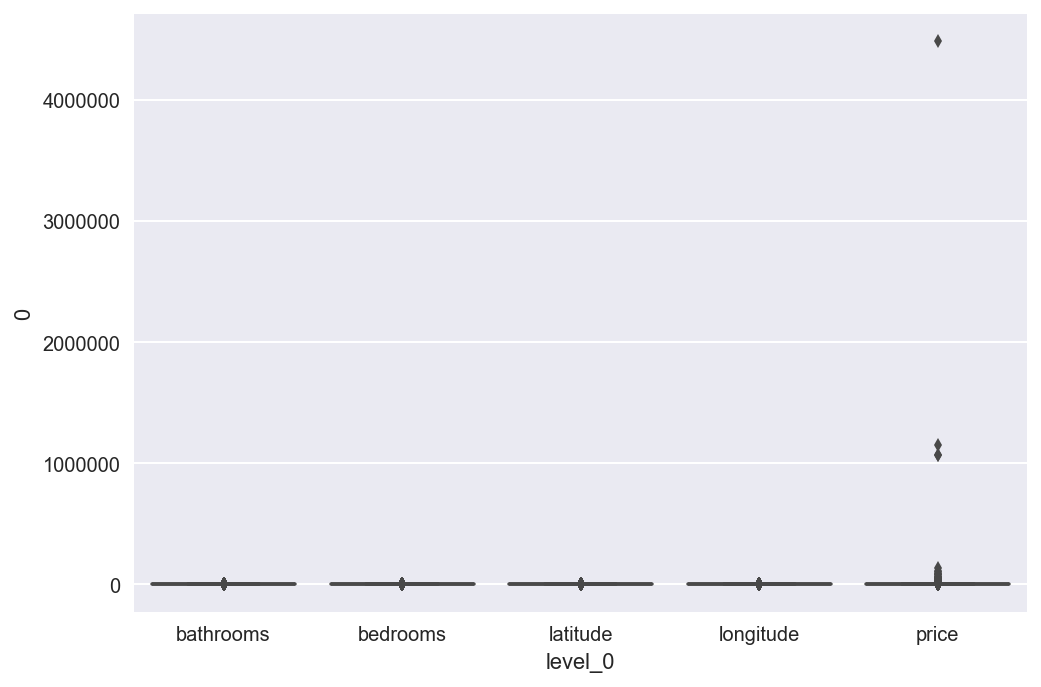

In [130]:
sns.boxplot(x='level_0', y='0', data=df_train[quant].unstack().rename('0').reset_index(level=0))

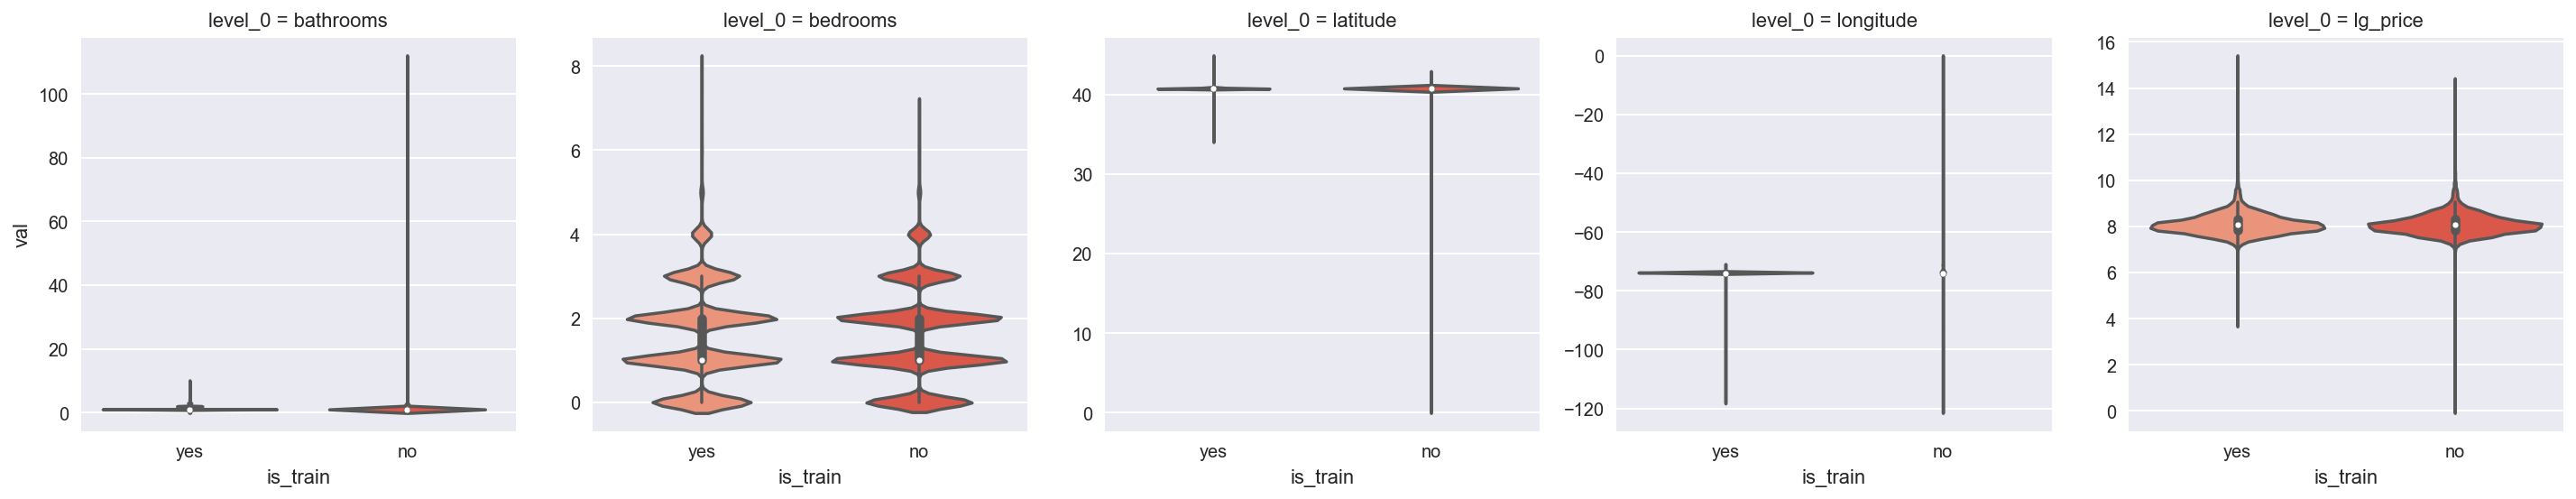

In [183]:
def basic_outl_drop(df):
    df = df.copy()
#     %%debug
#     import pdb; pdb.set_trace()
    df = df.loc[df.latitude!=0]
    df = df.loc[df.longitude!=0]
    df.price = np.log(df.price)
    df = df.rename(columns=dict(price='lg_price'))
    return df
    

data_tr_st = (df_train[quant].pipe(basic_outl_drop)
              .unstack()
              .rename('val')
              .reset_index(level=0)
)
data_te_st = (df_test[quant].pipe(basic_outl_drop)
              .unstack()
              .rename('val')
              .reset_index(level=0)
)
data = pd.concat([
    data_tr_st.assign(is_train='yes'),
    data_te_st.assign(is_train='no')
])
sns.factorplot(col='level_0', y='val', data=data, hue_order=['yes', 'no'],
               kind='violin', sharey=False, split=True, x='is_train')

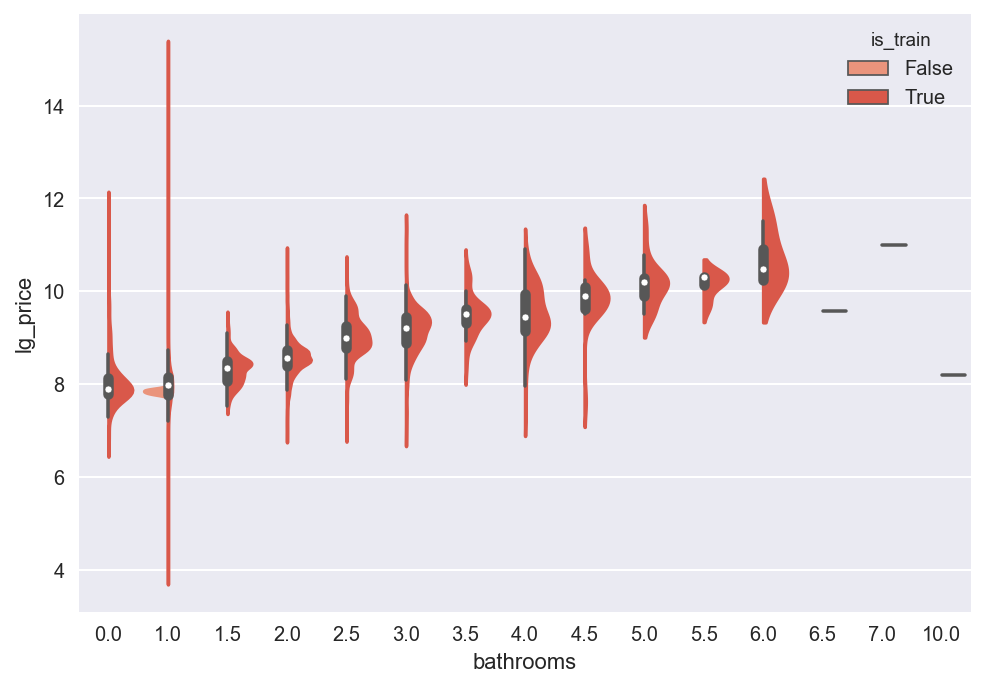

In [181]:
sns.violinplot(y='lg_price', 
               x='bathrooms',
               data=df_train.assign(is_train=df_train.latitude>40).pipe(basic_outl_drop),
               hue='is_train',
               split=True)

In [ ]:
def are_duplicated(df, normed=True):
    dupe_ns = []
    dupes = {}
    for name, ser in df.iteritems():
        print(name)
        print(type(ser))
        n = ser[ser.duplicated(keep=False)].sum()
        if type(n) is not int:
            %debug
        if normed:
            if type(n) is not int:
                print(n)
            n /= len(df)
        dupe_ns.append(n)
        dupes[name] = n
    
    return pd.DataFrame(dupes).T

are_duplicated(df)